# LSST SSP Daily Data Products Prototype Pipeline

This is the prototype code that takes _all_ observations of asteroids in LSST (the DIASources, expecting \~1Bn after 10yrs), computes additional quantities (another 1Bn rows; SSSources), and summarized per-object quantities (~10M rows; SSObjects).

It needs to run on a daily basis, and finish in ~1hr (final operational version).

Design principles:
* Design for code readability and speed.
* Always use vectorized ops (for loops are evil in Python).
* Utilize the available hardware (SSDs, large RAM machine), and design a solution that takes advantage of it if it results in a simpler code

Design:
* Represent tables as numpy structured arrays, maximally use vectorized ndarray ops.
* Mmap the arrays from disk files. Place these onto our NVME.
* Parallelize w. multiprocessing, by starting multiprocessing _after_ having mmapped the files. As child processes inherit open file descriptors, the mmapped files become writable by all of them (and there’s no need to exchange info via queues).
* Use pg_bulkload postgres extension to directly read these binary files and ingest them quickly into postgres.

Currently this notebook uses a few hardcoded paths on epyc.astro.washington.edu, and won't run elsewhere unless modified.

In [1]:
# add pymoid path
import sys
sys.path.append("/astro/users/mjuric" + "/projects/github.com/dirac-institute/pymoid")

In [2]:
import pandas as pd
import numpy as np
import astropy, astropy.coordinates
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

## Configuration

In [3]:
#input_dir = "detections/march_start_v2.1"
#output_dir = "outputs/march_start_v2.1"
#load_mpcorb = False

#input_dir = "detections2"
#output_dir = "outputs/oct2023_start_v3.0"
#load_mpcorb = False

input_dir = "detections2"
output_dir = "outputs/oct2023_v3.0_mpcorb"
load_mpcorb = True

## A look at the inputs

Assuming the inputs are in a bunch of Pandas-written HDF5 files (outputs of postprocessing by Cornwall et al.'s pipeline)

In [4]:
det = pd.read_hdf(f'{input_dir}/S0/visit-0000000.h5').reset_index()
#det = pd.read_hdf(f'{input_dir}/mpcorb/visit-0000000.h5').reset_index()
det

,index,ObjID,FieldID,FieldMJD,AstRange(km),AstRangeRate(km/s),AstRA(deg),AstRARate(deg/day),AstDec(deg),AstDecRate(deg/day),Ast-Sun(J2000x)(km),Ast-Sun(J2000y)(km),Ast-Sun(J2000z)(km),Ast-Sun(J2000vx)(km/s),Ast-Sun(J2000vy)(km/s),Ast-Sun(J2000vz)(km/s),Obs-Sun(J2000x)(km),Obs-Sun(J2000y)(km),Obs-Sun(J2000z)(km),Obs-Sun(J2000vx)(km/s),Obs-Sun(J2000vy)(km/s),Obs-Sun(J2000vz)(km/s),Sun-Ast-Obs(deg),V,V(H=0),fiveSigmaDepth,filter,MaginFilterTrue,AstrometricSigma(mas),PhotometricSigma(mag),SNR,AstrometricSigma(deg),MaginFilter,dmagDetect,dmagVignet,AstRATrue(deg),AstDecTrue(deg),detectorID
0,331,S000002qa,2628.0,60221.331673,9.808031e+07,13.318405,312.011833,2.451651,-76.907182,0.521360,1.620248e+08,8.557403e+06,-8.467178e+07,10.665853,24.608525,0.970452,1.471546e+08,2.506556e+07,1.085888e+07,-6.263202,26.960105,11.602638,54.761889,17.197172,1.517172,22.944821,i,16.742172,10.063972,0.002095,517.864549,0.000003,16.743403,0.181528,0.388753,312.011854,-76.907182,0
1,332,S000002qa,2678.0,60221.357001,9.810945e+07,13.313414,312.074031,2.459502,-76.893990,0.520535,1.620481e+08,8.611252e+06,-8.466965e+07,10.658178,24.608119,0.974463,1.471408e+08,2.512450e+07,1.088427e+07,-6.302328,26.899548,11.601791,54.750732,17.197760,1.517760,22.307871,z,16.796760,10.155858,0.003022,358.828959,0.000003,16.791489,0.158478,0.352810,312.074051,-76.893987,0
2,1718,S00000hMa,1020.0,60219.097416,1.003406e+08,-4.199834,351.542819,-0.803419,-12.009479,-0.049668,2.452667e+08,5.440671e+06,-1.226615e+07,-11.226932,12.175360,11.562249,1.481895e+08,1.987480e+07,8.612062e+06,-4.614056,27.295749,11.673250,13.285553,19.130061,0.982061,22.123762,y,18.724061,11.432747,0.011731,92.050664,0.000003,18.726291,0.241752,0.540032,351.542821,-12.009472,0
3,1721,S00000hMa,1070.0,60219.120621,1.003322e+08,-4.131996,351.524172,-0.804089,-12.010615,-0.048927,2.452442e+08,5.465081e+06,-1.224297e+07,-11.231336,12.175262,11.562469,1.481802e+08,1.992955e+07,8.635465e+06,-4.680521,27.315491,11.672713,13.307485,19.130473,0.982473,22.057988,y,18.724473,11.756275,0.012328,87.570146,0.000003,18.713001,0.219761,0.483108,351.524170,-12.010616,0
4,2086,S00000nDa,4696.0,60224.087688,1.952502e+08,17.450112,294.464581,0.270744,-13.372236,0.058236,2.242517e+08,-1.414996e+08,-3.154812e+07,9.578481,15.240421,9.688866,1.455848e+08,3.140222e+07,1.360869e+07,-7.129097,26.873391,11.489461,33.392139,21.734253,3.233253,23.596802,i,21.279253,15.962092,0.027625,38.804920,0.000004,21.304805,0.038588,0.787184,294.464583,-13.372240,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12479,14278,S0000okya,9002.0,60229.228593,5.978762e+07,-12.195616,20.101252,-0.374865,-8.941860,-0.591240,1.972408e+08,6.334222e+07,9.360397e+06,-20.871591,17.474414,6.050851,1.417774e+08,4.304412e+07,1.865332e+07,-10.053678,26.196982,11.209386,11.754144,23.090164,-0.566836,24.324882,r,22.835164,24.825609,0.055605,19.029968,0.000007,22.838051,0.259451,0.974071,20.101254,-8.941859,188
12480,14377,S0000p6Fa,6605.0,60226.288496,8.940452e+07,-11.980979,38.812510,-0.086143,0.407645,-0.081271,2.137545e+08,9.246050e+07,1.641952e+07,-17.051347,17.794467,9.828546,1.440922e+08,3.642548e+07,1.578343e+07,-8.699892,26.510023,11.381919,15.827903,24.406876,0.710876,24.300397,r,24.151876,76.807638,0.174863,5.722478,0.000021,23.850624,0.009384,0.296319,38.812522,0.407648,188
12481,14533,S0000qXia,4687.0,60224.083561,3.042685e+07,1.071659,305.815044,2.235104,-18.645574,0.831434,1.624577e+08,8.014194e+06,3.876727e+06,4.988201,32.338305,15.989165,1.455873e+08,3.139264e+07,1.360460e+07,-7.117533,26.869448,11.489627,59.458497,22.640644,-1.143356,23.710454,i,22.185644,25.420495,0.053959,19.625513,0.000007,22.143119,1.036534,0.228763,305.815040,-18.645585,188
12482,15440,S0000EPJa,9203.0,60229.322849,1.941330e+07,-2.541754,30.519326,0.109685,0.968063,1.917163,1.584159e+08,5.311398e+07,1.907257e+07,-12.771982,25.021042,18.677875,1.416946e+08,4.325675e+

In [5]:
det["FieldMJD"].min()

60218.00271524638

Datatypes check:

In [6]:
det.dtypes

index                       int64
ObjID                      object
FieldID                   float64
FieldMJD                  float64
AstRange(km)              float64
AstRangeRate(km/s)        float64
AstRA(deg)                float64
AstRARate(deg/day)        float64
AstDec(deg)               float64
AstDecRate(deg/day)       float64
Ast-Sun(J2000x)(km)       float64
Ast-Sun(J2000y)(km)       float64
Ast-Sun(J2000z)(km)       float64
Ast-Sun(J2000vx)(km/s)    float64
Ast-Sun(J2000vy)(km/s)    float64
Ast-Sun(J2000vz)(km/s)    float64
Obs-Sun(J2000x)(km)       float64
Obs-Sun(J2000y)(km)       float64
Obs-Sun(J2000z)(km)       float64
Obs-Sun(J2000vx)(km/s)    float64
Obs-Sun(J2000vy)(km/s)    float64
Obs-Sun(J2000vz)(km/s)    float64
Sun-Ast-Obs(deg)          float64
V                         float64
V(H=0)                    float64
fiveSigmaDepth            float64
filter                     object
MaginFilterTrue           float64
AstrometricSigma(mas)     float64
PhotometricSig

Check astrometric errors:

Text(0.5, 0, 'Separation (arcsec)')

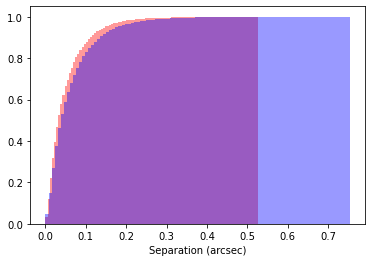

In [7]:
# from the file
obs = astropy.coordinates.SkyCoord(ra=det["AstRA(deg)"].values, dec=det["AstDec(deg)"].values, unit="deg")
tru = astropy.coordinates.SkyCoord(ra=det["AstRATrue(deg)"].values, dec=det["AstDecTrue(deg)"].values, unit="deg")
sep = obs.separation(tru)

# manually recompute
import numpy as np
err1d = 1./np.sqrt(2) * det["AstrometricSigma(deg)"]
newDec = np.random.normal(loc=det["AstDecTrue(deg)"], scale=err1d)
newRa = np.random.normal(loc=det["AstRATrue(deg)"], scale=err1d / np.cos(np.deg2rad(det["AstDecTrue(deg)"])))
newRa = np.fmod(newRa + 360, 360)
new = astropy.coordinates.SkyCoord(ra=newRa, dec=newDec, unit="deg")
old = astropy.coordinates.SkyCoord(ra=det["AstRA(deg)"].values, dec=det["AstDec(deg)"].values, unit="deg")
sep2 = new.separation(old)

# plot
plt.hist(sep.arcsec, bins=100, cumulative=True, density=True, alpha=0.4, color='red');   # from the file
plt.hist(sep2.arcsec, bins=100, cumulative=True, density=True, alpha=0.4, color='blue'); # manually computed
plt.xlabel("Separation (arcsec)")

## Create the DIASource Table

In [8]:
# A simple hashing function to convert names to 64bit IDs. 
# We'll use this to generate various primary key IDs from asteroid designations
import hashlib
def hashTo64(s):
    if not isinstance(s, str):
        s = str(s)
    return np.uint64(int.from_bytes(hashlib.sha224(s.encode("utf-8")).digest()[-8:], "little"))
hashTo64("foo"), hashTo64(12)

(15850672484136054362, 17586167158575412398)

In [9]:
# Let's make sure that the probability of hash collision is low
# ( using the usual p(collision) = n^2/(2*H) approximation)
14_000_000**2/(2*2**63)

1.0625181290357943e-05

In [10]:
# A function that takes the postprocessed input (as a DataFrame), and returns a dataframe with DIASource schema
#
def convertToDiaSource(det, validate=False):
    # create unique diaSourceId's by concatenating FieldID, ObjID and then hashing
    diaSourceId = (det["FieldID"].astype(str) + det["ObjID"]).apply(hashTo64).astype('uint64')
    assert np.all(diaSourceId.unique() == diaSourceId)
    df = pd.DataFrame({"diaSourceId": diaSourceId})

    # FIXME: ccdVisitId should be a combination of the CCD where the source was and the visitId
    #        see https://github.com/lsst/sdm_schemas/blob/master/sql/baselineSchema.sql#L2924
    # The postprocessor should output which CCD the object is on
    df["ccdVisitId"] = det["FieldID"].astype('uint32')

    # diaObjectId -- we'll this should be unique for all these, as we'll assume the detections won't overlap
    #   with any other detection thus not creating joint DiaObject. 
    # FIXME: The above won't be true -- an asteroid could come over a star or another asteroid. We need to
    #        figure this out for more precise sims later.
    df["diaObjectId"] = diaSourceId.apply(hashTo64).astype('uint64')
    if validate:
       assert np.all(df["diaObjectId"].unique() == df["diaObjectId"])

    # ssObjectId -- we'll create a unique 64bit int by just hashing the input ObjID
    df["ssObjectId"] = det["ObjID"].apply(hashTo64).astype('uint64')
    df["_name"] = det["ObjID"]
    if validate:
        # verify this generated unique IDs by grouping by the diaObjectId and checking each group has only one unique ObjID
        tmp = df[["ssObjectId"]].copy()
        tmp["ObjID"] = det["ObjID"]
        assert np.all(tmp.groupby("ssObjectId").agg(lambda x: len(np.unique(x))) == 1)
        del tmp

    # parentDiaSourceId, prv_procOrder
    ##df["parentDiaSourceId"] = np.nan
    ##df["prv_procOrder"] = np.nan

    # Assume everything is discovered immediately
    # FIXME: improve when we start doing actual linking, this will then be the time when we linked
    #        the object for the first detection, and then immediate once object is attributable in
    #        real time
    df["ssObjectReassocTime"] = det["FieldMJD"]

    # astrometry.
    # FIXME: We're assuming the astrometry has no covariance, while in reality it will. We could
    # at least have it be orhogonal in the row,col direction on the CCD.
    df["midPointTai"] = det["FieldMJD"]
    df["ra"] = det["AstRA(deg)"]
    df["raSigma"] = (1./np.sqrt(2) * det["AstrometricSigma(deg)"]).astype('float32')
    df["decl"] = det["AstDec(deg)"]
    df["declSigma"] = (1./np.sqrt(2) * det["AstrometricSigma(deg)"]).astype('float32')
    df["ra_decl_Cov"] = np.float32(0.)

    # CCD location
    # FIXME: compute this
    ##df["x"] = df["y"] = np.nan
    ##df["xSigma"] = df["ySigma"] = df["x_y_Cov"] = np.nan

    # SNR
    df["snr"] = det["SNR"].astype('float32')

    # Fields that aren't in the official schema (but should be, IMHO)
    df["filter"] = det["filter"]
    df["mag"] = det["MaginFilter"].astype('float32')
    df["magSigma"] = det["PhotometricSigma(mag)"].astype('float32')

    # Truth values
    df["_V"] = det["V"].astype('float32')
    df["_magTrue"] = det["MaginFilterTrue"].astype('float32')
    df["_raTrue"] = det["AstRATrue(deg)"]
    df["_decTrue"] = det["AstDecTrue(deg)"]

    return df

# display
df = convertToDiaSource(det, validate=True)
print(df.dtypes)

# array conversions and checks
arr = np.asarray(df.to_records(index=False, column_dtypes={"filter": "S1", "_name": "S16"}))
#print(arr.dtype.fields)
for colname, (t, _) in arr.dtype.fields.items():
    assert t != np.dtype('O'), f"'{colname}'' is an object type; add it to column_dtypes"

diaSourceId             uint64
ccdVisitId              uint32
diaObjectId             uint64
ssObjectId              uint64
_name                   object
ssObjectReassocTime    float64
midPointTai            float64
ra                     float64
raSigma                float32
decl                   float64
declSigma              float32
ra_decl_Cov            float32
snr                    float32
filter                  object
mag                    float32
magSigma               float32
_V                     float32
_magTrue               float32
_raTrue                float64
_decTrue               float64
dtype: object


In [11]:
df

,diaSourceId,ccdVisitId,diaObjectId,ssObjectId,_name,ssObjectReassocTime,midPointTai,ra,raSigma,decl,declSigma,ra_decl_Cov,snr,filter,mag,magSigma,_V,_magTrue,_raTrue,_decTrue
0,10277570196971898777,2628,6199909147676580033,473550324317041092,S000002qa,60221.331673,60221.331673,312.011833,0.000002,-76.907182,0.000002,0.0,517.864563,i,16.743402,0.002095,17.197172,16.742172,312.011854,-76.907182
1,18311177223742886888,2678,15922723011543734569,473550324317041092,S000002qa,60221.357001,60221.357001,312.074031,0.000002,-76.893990,0.000002,0.0,358.828949,z,16.791489,0.003022,17.197760,16.796761,312.074051,-76.893987
2,17675345958853466011,1020,1058421775347369340,2278645189200825111,S00000hMa,60219.097416,60219.097416,351.542819,0.000002,-12.009479,0.000002,0.0,92.050667,y,18.726292,0.011731,19.130060,18.724060,351.542821,-12.009472
3,15775424059463636914,1070,4621218203182066267,2278645189200825111,S00000hMa,60219.120621,60219.120621,351.524172,0.000002,-12.010615,0.000002,0.0,87.570145,y,18.713001,0.012328,19.130474,18.724474,351.524170,-12.010616
4,7309699707561263687,4696,16017436406562527876,3346960137293008566,S00000nDa,60224.087688,60224.087688,294.464581,0.000003,-13.372236,0.000003,0.0,38.804920,i,21.304806,0.027625,21.734253,21.279253,294.464583,-13.372240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12479,1270280127639300719,9002,9926918714924033826,14197676294747813584,S0000okya,60229.228593,60229.228593,20.101252,0.000005,-8.941860,0.000005,0.0,19.029968,r,22.838051,0.055605,23.090164,22.835165,20.101254,-8.941859
12480,16526563573780722957,6605,10823008425760192104,8038374877264180988,S0000p6Fa,60226.288496,60226.288496,38.812510,0.000015,0.407645,0.000015,0.0,5.722478,r,23.850624,0.174863,24.406876,24.151876,38.812522,0.407648
12481,2130961515609428146,4687,17652391851812038039,7268123465472714744,S0000qXia,60224.083561,60224.083561,305.815044,0.000005,-18.645574,0.000005,0.0,19.625513,i,22.143120,0.053959,22.640644,22.185644,305.815040,-18.645585
12482,944963345961682325,9203,10027135598496255975,10562176464592212869,S0000EPJa,60229.322849,60229.322849,30.519326,0.000002,0.968063,0.000002,0.0,83.798615,r,20.616858,0.012880,20.888489,20.633488,30.519325,0.968064


## Create a single, huge, mmapped array for the DIASource table

The strategy:
* Find out how many DIASources we'll have, by scanning all input files
* Create huge mmapped array with the DIASource schema, and the expected number of rows
* Iterate (in parallel) through all input files, converting each one of them into the DIASource schema, and then writing them out into the right place of the big mmapped array

In [12]:
# all input files
import glob
detFiles = glob.glob(f"{input_dir}/S*/visit-*.h5")

if load_mpcorb:
    detFiles = glob.glob(f"{input_dir}/mpcorb/visit-*.h5") + detFiles

In [13]:
def scanInputs(inputs):
    import tables
    from tqdm.notebook import tqdm

    ret = {}
    for fn in tqdm(inputs):
        with tables.open_file(fn) as fp:
            try:
                ret[fn] = fp.root.data.table.shape[0]
            except tables.NoSuchNodeError:
                # empty file
                pass

    # convert to dataframe with sizes and offsets
    df = pd.DataFrame(ret.items(), columns=["filename", "size"])
    df["offset"] = df["size"].cumsum() - df["size"]
    assert df.iloc[-1]["offset"] + df.iloc[-1]["size"] == df["size"].sum()
    
    return df

inputs = scanInputs(detFiles)
nrows = sum(inputs['size'])
print(f"Total observations: {nrows}")

  0%|          | 0/3895 [00:00<?, ?it/s]

Total observations: 1456988142


The file names of memory-mapped arrays, and aux functions to open/create them.

In [14]:
diaFn = f"{output_dir}/diaSource.npy"
sssFn = f"{output_dir}/ssSource.npy"
objFn = f"{output_dir}/ssObject.npy"
mpcFn = f"{output_dir}/mpcorb.npy"

In [15]:
import mmap, os
MAP_POPULATE = 0x08000
MAP_LOCKED = 0x2000

def openOrCreateArray(dbfn, nrows, dtype, clobber=False):
    if clobber:
        try:
            os.unlink(dbfn)
        except FileNotFoundError:
            pass

#    ! dd if=/dev/zero of={dbfn} bs=1M count={int((nrows*arr.dtype.itemsize)/(1024*1024))} conv=fdatasync,notrunc status=progress oflag=direct
    if os.path.exists(dbfn):
        # if the file exists, the size must match the expectation
        assert nrows*dtype.itemsize == os.path.getsize(dbfn)
        print(f"Opening existing file {dbfn}")

    fp = os.open(dbfn, os.O_RDWR | os.O_CREAT)# | os.O_DIRECT)
    os.ftruncate(fp, nrows*dtype.itemsize)
    mm = mmap.mmap(fp, 0, flags=mmap.MAP_SHARED | MAP_POPULATE)
    arr = np.ndarray(shape=(nrows,), dtype=dtype, buffer=mm)
    
    return arr, mm, fp

def closeArray(mm_obj, fp):
    import os
    mm_obj.close()
    os.close(fp)

We'll create the SSSource table at the same time, as many of the fields in it are already present in the input data which we're about to read. Define the schema first.

In [16]:
ssSourceDtype = np.dtype([
    ('ssObjectId', 'u8'),
    ('diaSourceId', 'u8'),
    ('mpcUniqueId', 'u8'),
    ('eclipticLambda', 'f8'),
    ('eclipticBeta', 'f8'),
    ('galacticL', 'f8'),
    ('galacticB', 'f8'),
    ('phaseAngle', 'f4'),
    ('heliocentricDist', 'f8'),
    ('topocentricDist', 'f8'),
    ('predictedMagnitude', 'f4'),
    ('predictedMagnitudeSigma', 'f4'),
    ('residualRa', 'f4'),
    ('residualDec', 'f4'),
    ('predictedRaSigma', 'f4'),
    ('predictedDecSigma', 'f4'),
    ('predictedRaDecCov', 'f4'),
    ('heliocentricX', 'f8'),
    ('heliocentricY', 'f8'),
    ('heliocentricZ', 'f8'),
    ('heliocentricVX', 'f8'),
    ('heliocentricVY', 'f8'),
    ('heliocentricVZ', 'f8'),
    ('topocentricX', 'f8'),
    ('topocentricY', 'f8'),
    ('topocentricZ', 'f8'),
    ('topocentricVX', 'f8'),
    ('topocentricVY', 'f8'),
    ('topocentricVZ', 'f8')
])
ssSourceDtype.itemsize, arr.itemsize

(200, 125)

Now create the memory mapped arrays which we'll write into. These are intentionally in global variables, so when multiprocessing forks the worker processes they will automatically inherit the open memory mapping.

In [17]:
dia, dia_mm, dia_fp = openOrCreateArray(diaFn, nrows, arr.dtype)

Opening existing file outputs/oct2023_v3.0_mpcorb/diaSource.npy


In [18]:
sss, sss_mm, sss_fp = openOrCreateArray(sssFn, nrows, ssSourceDtype)

Opening existing file outputs/oct2023_v3.0_mpcorb/ssSource.npy


In [19]:
! ls -lh {output_dir}/*.npy

-rwxrwxr-x 1 mjuric mjuric 170G Mar 25 10:06 outputs/oct2023_v3.0_mpcorb/diaSource.npy
-rwxrwxr-x 1 mjuric mjuric 2.9G Mar 16 20:03 outputs/oct2023_v3.0_mpcorb/mpcorb.npy
-rwxrwxr-x 1 mjuric mjuric 2.6G Mar 20 04:57 outputs/oct2023_v3.0_mpcorb/ssObject.npy
-rwxrwxr-x 1 mjuric mjuric 272G Mar 25 10:07 outputs/oct2023_v3.0_mpcorb/ssSource.npy


Iterate through all files and populate the memory-mapped array for the DIASource and SSSource tables.

In [23]:
def _createDiaSourceTable_mapper(item):
    fn, size, offset = item
    import time, sys
    
    # load
    t0 = time.perf_counter()
    try:
        det = pd.read_hdf(fn).reset_index()
    except:
        print("ERROR: ", output)
        return (output, 0)
    t_read = time.perf_counter() - t0

    # convert DiaSource
    df = convertToDiaSource(det)
    arr = np.asarray(df.to_records(index=False, column_dtypes={"filter": "S1"}))
    assert size == arr.size

    # a very simple checksum
    cksum = df["ccdVisitId"].sum()

    # store to array
    t0 = time.perf_counter()
    dia[offset:offset + size] = arr
    t_write = time.perf_counter() - t0

    #
    # construct SSSource
    #
    # FIXME: this should all be _computed_ from the orbit, not taken from the simulated inputs
    ss = sss[offset:offset + size]
    ss["ssObjectId"] = df["ssObjectId"].values
    ss["diaSourceId"] = df["diaSourceId"].values
    ss["mpcUniqueId"] = 0

    from astropy.coordinates import SkyCoord, HeliocentricEclipticIAU76
    import astropy.units as u
    p = SkyCoord(ra=det["AstRA(deg)"].values*u.deg, dec=det["AstDec(deg)"].values*u.deg, distance=1*u.au, frame='hcrs')
    ecl = p.transform_to(HeliocentricEclipticIAU76)
    p = SkyCoord(ra=det["AstRA(deg)"].values*u.deg, dec=det["AstDec(deg)"].values*u.deg, distance=1*u.au, frame='icrs')
    gal = p.transform_to('galactic')

    ss["eclipticLambda"] = ecl.lon
    ss["eclipticBeta"] = ecl.lat
    ss["galacticL"] = gal.l
    ss["galacticB"] = gal.b

    au = (u.AU).to(u.km)
    au_day = (u.AU / u.day).to(u.km / u.s)

    ss["phaseAngle"] = det["Sun-Ast-Obs(deg)"]
    ss['predictedMagnitude'] = np.nan
    ss['predictedMagnitudeSigma'] = np.nan
    ss['residualRa'] = np.nan
    ss['residualDec'] = np.nan
    ss['predictedRaSigma'] = np.nan
    ss['predictedDecSigma'] = np.nan
    ss['predictedRaDecCov'] = np.nan
    ss['heliocentricX'] = det["Ast-Sun(J2000x)(km)"].values / au
    ss['heliocentricY'] = det["Ast-Sun(J2000y)(km)"].values / au
    ss['heliocentricZ'] = det["Ast-Sun(J2000z)(km)"].values / au
    ss['heliocentricVX'] = det["Ast-Sun(J2000vx)(km/s)"].values / au_day
    ss['heliocentricVY'] = det["Ast-Sun(J2000vy)(km/s)"].values / au_day
    ss['heliocentricVZ'] = det["Ast-Sun(J2000vz)(km/s)"].values / au_day
    ss['topocentricX'] = (det["Ast-Sun(J2000x)(km)"].values - det["Obs-Sun(J2000x)(km)"].values) / au
    ss['topocentricY'] = (det["Ast-Sun(J2000y)(km)"].values - det["Obs-Sun(J2000y)(km)"].values) / au
    ss['topocentricZ'] = (det["Ast-Sun(J2000z)(km)"].values - det["Obs-Sun(J2000z)(km)"].values) / au
    ss['topocentricVX'] = (det["Ast-Sun(J2000vx)(km/s)"].values - det["Obs-Sun(J2000vx)(km/s)"].values) / au_day
    ss['topocentricVY'] = (det["Ast-Sun(J2000vy)(km/s)"].values - det["Obs-Sun(J2000vy)(km/s)"].values) / au_day
    ss['topocentricVZ'] = (det["Ast-Sun(J2000vz)(km/s)"].values - det["Obs-Sun(J2000vz)(km/s)"].values) / au_day
    ss['heliocentricDist'] = np.sqrt(ss['heliocentricX']**2 + ss['heliocentricY']**2 + ss['heliocentricZ']**2)
    ss['topocentricDist'] = np.sqrt(ss['topocentricX']**2 + ss['topocentricY']**2 + ss['topocentricZ']**2)

    return (fn, len(df), cksum, (t_read, t_write))

def createDiaSourceTable(inputs):
    import os
    from functools import partial
    from tqdm.notebook import tqdm

    from multiprocessing import Pool
    with Pool(48) as p:
        outputs = list(tqdm(
            p.imap(
                _createDiaSourceTable_mapper, inputs.itertuples(index=False, name=None)
            ), total=len(inputs)
        ))

    nrows = sum(i for _, i, _, _ in outputs)
    cksum = sum(i for _, _, i, _ in outputs)
    
    return nrows, cksum, outputs

nrows, cksum, outputs = createDiaSourceTable(inputs)
#_createDiaSourceTable_mapper(tuple(inputs.loc[0]))

print(f"Converted {nrows} rows (checksum={cksum}).")

  0%|          | 0/3895 [00:00<?, ?it/s]

Converted 1456988142 rows (checksum=1499790545061113).


A quick-and-dirty check that everything went well:

In [25]:
%%time
cksum2 = dia["ccdVisitId"].sum()
cksum2

CPU times: user 29.1 s, sys: 13.3 s, total: 42.5 s
Wall time: 42.7 s


1499790545061113

In [26]:
assert cksum == cksum2

## Let's find all unique objects

Need to find all unique objects in the input, as we'll be generating the SSObject table object by object. This is what pandas.groupby() does in the background, but Pandas is too slow and RAM-inefficient to be useful here so we'll have to do it old school.

Optimization: Load the saved indices if you've already generated them, or skip the next cell and execute the cells below to create it.

In [20]:
import pickle
with open(f"{output_dir}/indices.pkl", "rb") as ff:
    i = pickle.load(ff)
    ssObjectId = pickle.load(ff)
    ssObjects = pickle.load(ff)
    splits = pickle.load(ff)
    nobj = pickle.load(ff)

Execute these cells to build the necessary indices. If you've successfully run the cell above, DONT RUN THESE.

In [27]:
%%time
# i is an ndarray that would sort `dia` by ssObjectId
# this takes about ~10 minutes on epyc
i = np.argsort(dia["ssObjectId"])

CPU times: user 18min 3s, sys: 1min 19s, total: 19min 23s
Wall time: 19min 32s


In [28]:
%%time
# a sorted list of ssObjectIds
# this takes 2-3 minutes on epyc
ssObjectId = dia["ssObjectId"][i]

CPU times: user 3min 51s, sys: 9min 49s, total: 13min 40s
Wall time: 48min 45s


In [29]:
%%time
# a list of unique ssObjects, and an index idx of the row in ssObjectId where the corresponding entry
# in ssObject appears first. This is useful for groupby type operations.
ssObjects, idx = np.unique(ssObjectId, return_index=True)

CPU times: user 17.5 s, sys: 39 s, total: 56.5 s
Wall time: 57.5 s


In [30]:
%%time
# create the "group by" splits for individual objects (takes ~1 minute on epyc)
# See https://stackoverflow.com/a/43094244 for inspiration for this code
#
# (ssObjects, splits) are a 1:1 map -- for each ssObject, the corresponding entry in
# splits are the indices in dia where its rows are.
#
# FIXME: should this be a dict (?)
splits = np.split(i, idx[1:])
assert len(splits) == ssObjects.size

CPU times: user 27.8 s, sys: 1.85 s, total: 29.6 s
Wall time: 29.7 s


In [31]:
nobj = len(ssObjects)

Write out the results so we can recover quickly if the kernel is restarted.

In [32]:
import pickle
with open(f"{output_dir}/indices.pkl", "wb") as ff:
    pickle.dump(i, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(ssObjectId, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(ssObjects, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(splits, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(nobj, ff, protocol=pickle.HIGHEST_PROTOCOL)

## Build the MPCORB Table

Just read and reformat the S3M files (quick and dirty). Load everything into RAM (it's small).

In [21]:
def load_mpcorb_ssm():
    dtyp={
        "id": str,
        "q": 'f8',
        "e": 'f8',
        "i": 'f8',
        "O": 'f8',
        "o": 'f8',
        "tp": 'f8',
        "H": 'f4',
        "epoch": 'f8'
    }
    usecols=["id", "q", "e", "i", "O", "o", "tp", "H", "epoch"]
    df = pd.read_csv("orbits/mpcorb_20220222_COM.ssm", header=None, skiprows=1,
                     names="q e i O o tp epoch H id".split(), 
                     usecols=usecols,
                     dtype=dtyp, delim_whitespace=True)
    df["format"] = "COM"
    return df

In [22]:
names=["id", "format", "q", "e", "i", "O", "o", "tp", "H", "epoch", "idx", "npar", "moid", "cc"]
usecols=["id", "format", "q", "e", "i", "O", "o", "tp", "H", "epoch"]
dtyp={
    "id": str,
    "format": str,
    "q": 'f8',
    "e": 'f8',
    "i": 'f8',
    "O": 'f8',
    "o": 'f8',
    "tp": 'f8',
    "H": 'f4',
    "epoch": 'f8'
}

dfs = []
from tqdm.notebook import tqdm
mpcinputs = glob.glob("S3M_v09.05.15/S*.s3m")
mpcinputs.remove("S3M_v09.05.15/SH.s3m") # FIXME: this one has duplicate names with S0 (???)
for fn in tqdm(mpcinputs):
    try:
        df = pd.read_csv(fn, header=None, skiprows=2, names=names, usecols=usecols, dtype=dtyp, delim_whitespace=True)
    except ValueError:
        # some files have an extra column
        df = pd.read_csv(fn, header=None, skiprows=2, names=names + ["_"], usecols=usecols, dtype=dtyp, delim_whitespace=True)
    dfs.append(df)

if load_mpcorb:
    dfs.append(load_mpcorb_ssm())

df = pd.concat(dfs)
del dfs

nmpc = len(df)
print(f"Loaded {nmpc} rows")
df

  0%|          | 0/22 [00:00<?, ?it/s]

Loaded 15777878 rows


,id,format,q,e,i,O,o,tp,H,epoch
0,SR000001a,COM,7.887210,0.569040,5.01607,66.70177,47.02487,52354.06796,7.950000,54800.0
1,SR000002a,COM,7.900480,0.072720,12.20203,149.76906,111.14332,54255.95952,11.900000,54800.0
2,SR000003a,COM,18.938420,0.258530,16.23096,157.72377,86.93460,32718.27775,7.580000,54800.0
3,SR000004a,COM,8.901490,0.163720,10.94138,318.01916,357.05184,49162.23730,12.990000,54800.0
4,SR000006a,COM,14.564980,0.356830,18.91729,292.49508,302.03901,-13278.77515,9.280000,54800.0
...,...,...,...,...,...,...,...,...,...,...
1177571,mpc1177571,COM,42.551975,0.012956,13.74893,198.76661,0.12185,59308.87995,7.900000,59300.0
1177572,mpc1177572,COM,35.869432,0.085654,17.06006,13.19938,185.02669,59308.93498,8.500000,59300.0
1177573,mpc1177573,COM,41.573625,0.013471,0.50123,130.87114,67.75883,59308.90141,8.100000,59300.0
1177574,mpc1177574,COM,1.555372,0.280549,27.28853,121.03255,97.84464,59379.91684,18.900000,59320.0


Quick sanity checks

In [23]:
assert df["i"].min() >= 0 and df["i"].max() < 180
assert df["O"].min() >= 0 and df["O"].max() < 360, (df["O"].min(), df["O"].max())
assert df["o"].min() >= 0 and df["o"].max() < 360, (df["o"].min(), df["o"].max())

In [24]:
# There should be no duplicate names
mask = df[["id"]].duplicated(keep=False)
assert np.any(mask) == False, "Duplicate names! Uncomment the next line to debug"
# df[mask].sort_values(by='id')

MPCORB schema

In [25]:
mpcorbDtype = np.dtype([
    ('mpcDesignation', 'S16'),
    ('mpcNumber', 'i4'),
    ('ssObjectId', 'u8'),
    ('mpcH', 'f4'),
    ('mpcG', 'f4'),
    ('epoch', 'f8'),
    ('tperi', 'f8'),
    ('peri', 'f8'),
    ('node', 'f8'),
    ('incl', 'f8'),
    ('e', 'f8'),
    ('n', 'f8'),
    ('q', 'f8'),
    ('uncertaintyParameter', 'S1'),
    ('reference', 'S9'),
    ('nobs', 'i4'),
    ('nopp', 'i4'),
    ('arc', 'f4'),
    ('arcStart', 'f8'),
    ('arcEnd', 'f8'),
    ('rms', 'f4'),
    ('pertsShort', 'S3'),
    ('pertsLong', 'S3'),
    ('computer', 'S10'),
    ('flags', 'i4'),
    ('fullDesignation', 'S26'),
    ('lastIncludedObservation', 'f4')
])
mpcorbDtype.itemsize

192

Create the table on disk:

In [26]:
mpc, mpc_mm, mpc_fp = openOrCreateArray(mpcFn, nmpc, mpcorbDtype)

Opening existing file outputs/oct2023_v3.0_mpcorb/mpcorb.npy


Populate it with the dataframe contents:

In [39]:
mpc["mpcDesignation"] = df["id"].values
mpc["mpcNumber"] = 0
mpc["ssObjectId"] = df["id"].apply(hashTo64).astype('uint64').values
mpc["mpcH"] = df["H"].values
mpc["mpcG"] = 0.15  # FIXME: check what we actually used?
mpc["epoch"] = df["epoch"].values
mpc["tperi"] = df["tp"].values
mpc["peri"] = df["o"].values
mpc["node"] = df["O"].values
mpc["incl"] = df["i"].values
mpc["e"] = df["e"].values
mpc["q"] = df["q"].values

In [40]:
mpc["n"] = np.nan
mpc["arc"] = np.nan
mpc["arcStart"] = np.nan
mpc["arcEnd"] = np.nan
mpc["rms"] = np.nan
mpc["lastIncludedObservation"] = np.nan

In [41]:
mpc["fullDesignation"] = np.char.add("2011 ", df["id"].values)

In [27]:
pd.DataFrame(mpc[:10])

,mpcDesignation,mpcNumber,ssObjectId,mpcH,mpcG,epoch,tperi,peri,node,incl,e,n,q,uncertaintyParameter,reference,nobs,nopp,arc,arcStart,arcEnd,rms,pertsShort,pertsLong,computer,flags,fullDesignation,lastIncludedObservation
0,b'SR000001a',0,15788168397775243006,7.95,0.15,54800.0,52354.06796,47.02487,66.70177,5.01607,0.56904,NaN,7.88721,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000001',NaN
1,b'SR000002a',0,1638696702905544284,11.90,0.15,54800.0,54255.95952,111.14332,149.76906,12.20203,0.07272,NaN,7.90048,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000002',NaN
2,b'SR000003a',0,12298016463469666278,7.58,0.15,54800.0,32718.27775,86.93460,157.72377,16.23096,0.25853,NaN,18.93842,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000003',NaN
3,b'SR000004a',0,2476339031007217136,12.99,0.15,54800.0,49162.23730,357.05184,318.01916,10.94138,0.16372,NaN,8.90149,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000004',NaN
4,b'SR000006a',0,12007666665710405350,9.28,0.15,54800.0,-13278.77515,302.03901,292.49508,18.91729,0.35683,NaN,14.56498,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000006',NaN
5,b'SR000007a',0,2288881953631168399,13.62,0.15,54800.0,18336.22381,118.09495,346.28496,12.14507,0.58636,NaN,6.16097,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000007',NaN
6,b'SR00000ca',0,14715048992292693248,7.68,0.15,54800.0,-41359.98457,101.95296,285.86234,9.14592,0.68406,NaN,8.65433,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR00000c',NaN
7,b'SR00000da',0,17479967543176965816,13.43,0.15,54800.0,38343.47314,278.96507,265.57938,5.90244,0.34417,NaN,5.38205,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR00000d',NaN
8,b'SR00000fa',0,13102266129618180363,6.30,0.15,54800.0,53366.71169,177.46067,134.56080,30.16544,0.20250,NaN,7.88358,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR00000f',NaN
9,b'SR00000ha',0,17927196771923220462,11.22,0.15,54800.0,-11184.16621,16.07536,183.54684,14.24878,0.26652,NaN,16.19823,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR00000h',NaN


See if there are any objects in ssObjects that aren't in the catalog.

In [28]:
ok = pd.Series(ssObjects).isin(mpc['ssObjectId'])
assert ok.all()
del ok

## Compute the SSObjects Table

Let's define the schema of our SSObjects table.
FIXME: We should really get this with felis or something LSST-official.

In [29]:
ssObjectDtype = np.dtype([
    ('ssObjectId', 'u8'),
    ('discoverySubmissionDate', 'f8'),
    ('firstObservationDate', 'f8'),
    ('arc', 'f4'),
    ('numObs', 'u4'),
#    ('lcPeriodic', 'b768'),
    ('MOID', 'f4'),
    ('MOIDTrueAnomaly', 'f4'),
    ('MOIDEclipticLongitude', 'f4'),
    ('MOIDDeltaV', 'f4'),
    ('uH', 'f4'),
    ('uG12', 'f4'),
    ('uHErr', 'f4'),
    ('uG12Err', 'f4'),
    ('uH_uG12_Cov', 'f4'),
    ('uChi2', 'f4'),
    ('uNdata', 'u4'),
    ('gH', 'f4'),
    ('gG12', 'f4'),
    ('gHErr', 'f4'),
    ('gG12Err', 'f4'),
    ('gH_gG12_Cov', 'f4'),
    ('gChi2', 'f4'),
    ('gNdata', 'u4'),
    ('rH', 'f4'),
    ('rG12', 'f4'),
    ('rHErr', 'f4'),
    ('rG12Err', 'f4'),
    ('rH_rG12_Cov', 'f4'),
    ('rChi2', 'f4'),
    ('rNdata', 'u4'),
    ('iH', 'f4'),
    ('iG12', 'f4'),
    ('iHErr', 'f4'),
    ('iG12Err', 'f4'),
    ('iH_iG12_Cov', 'f4'),
    ('iChi2', 'f4'),
    ('iNdata', 'u4'),
    ('zH', 'f4'),
    ('zG12', 'f4'),
    ('zHErr', 'f4'),
    ('zG12Err', 'f4'),
    ('zH_zG12_Cov', 'f4'),
    ('zChi2', 'f4'),
    ('zNdata', 'u4'),
    ('yH', 'f4'),
    ('yG12', 'f4'),
    ('yHErr', 'f4'),
    ('yG12Err', 'f4'),
    ('yH_yG12_Cov', 'f4'),
    ('yChi2', 'f4'),
    ('yNdata', 'u4'),
    ('maxExtendedness', 'f4'),
    ('minExtendedness', 'f4'),
    ('medianExtendedness', 'f4'),
    ('flags', 'u8'),
])
ssObjectDtype.itemsize

236

Create the table on disk:

In [30]:
obj, obj_mm, obj_fp = openOrCreateArray(objFn, nobj, ssObjectDtype)

Opening existing file outputs/oct2023_v3.0_mpcorb/ssObject.npy


Phase curve fitter:

9.988756458227645 0.13952960708387724 χ2/dof = 0.8331755508444011


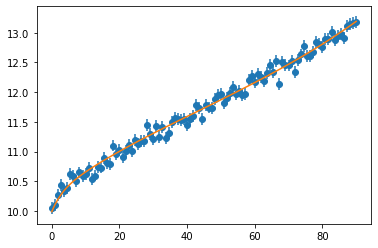

In [31]:
import warnings
from astropy.modeling.fitting import LevMarLSQFitter

def fitHG(mag, magSigma, phaseAngle, tdist, rdist):
    # Description of the (H, G) system:
    #    https://www.britastro.org/asteroids/dymock4.pdf
    nobsv = len(mag)

    # correct the mag to 1AU distance
    dmag = -5. * np.log10(tdist*rdist)
    mag = mag + dmag
    phaseAngle = np.deg2rad(phaseAngle)
    wt = 1./magSigma

    # fit
    fitter = LevMarLSQFitter()
    obs = dict(
        alpha=phaseAngle,
        r=mag*0 + 1,
        mag=mag
        )
    # astropy emits a console warning every time the fitter fails (annoying)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = HG.from_obs(obs, fitter, weights=wt)

    # extract the covariance matrix
    fi = fitter.fit_info
    if 1 <= fi['ierr'] <= 4:
        # fit succeeded
        cov = fi['param_cov']
        sigmaH, sigmaG, covHG = np.sqrt(cov[0,0]), np.sqrt(cov[1,1]), cov[0,1]

        # calculate chi^2/dof
        _mag = HG.evaluate(phaseAngle, res.H.value, res.G.value)
        chi2dof = np.sum(((mag - _mag)*wt)**2.) / (nobsv-len(res.parameters))
        
        return res.H.value, res.G.value, sigmaH, sigmaG, covHG, chi2dof, nobsv
    else:
        # fit failed
        return (np.nan,) * 6 + (0,)
    
# Test of magnitude fitting

from sbpy.photometry import HG
ph = np.linspace(0, 90, 100)
mag = HG.evaluate(np.deg2rad(ph), 10, 0.14)
np.random.seed(42)
sigma = 0.1
mag = np.random.normal(mag, sigma)

H, G, sigmaH, sigmaG, covHG, chi2dof, nobsv = fitHG(mag, sigma, ph, 1., 1.)

plt.scatter(ph, mag)
plt.errorbar(ph, mag, sigma, ls='none')
_ph = sorted(ph)
_mag = HG.evaluate(np.deg2rad(ph), H, G)
plt.plot(_ph, _mag)
print(H, G, f"χ2/dof = {chi2dof}")

Many of the cells below are just for validation/debugging and can be skipped over.

H=18.82±0.002, G=0.14±0.00264, χ2/dof=0.002
[b'S100uH5sa']


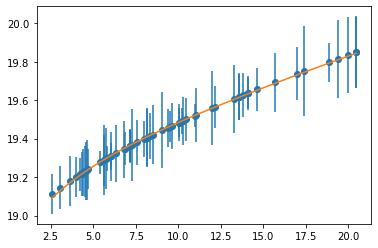

In [32]:
# Test:
# Extract the needed data from the DiaSource and SSSource tables
band = "r".encode("ascii")
_i = splits[5]
obsv = dia[["filter", "mag", "magSigma", "_magTrue", "_name"]][_i]
_sss = sss[["phaseAngle", "topocentricDist", "heliocentricDist"]][_i]

mask = obsv['filter'] == band
obsv = obsv[mask]
_sss = _sss[mask]
mag = obsv["_magTrue"]
#mag = obsv["mag"]
#print(pd.DataFrame(obsv))
#print(pd.DataFrame(_sss))

assert np.all(obsv["filter"] == band)
H, G, sigmaH, sigmaG, covHG, chi2dof, nobsv = \
    fitHG(mag, obsv["magSigma"], _sss["phaseAngle"], _sss["topocentricDist"], _sss["heliocentricDist"])

# plot distance-corrected data
mag1 = mag -5. * np.log10(_sss["topocentricDist"]*_sss["heliocentricDist"])
p = _sss["phaseAngle"]
plt.scatter(p, mag1)
plt.errorbar(p, mag1, obsv["magSigma"], ls='none')

# best-fit overplot
_ph = sorted(p)
_mag = HG.evaluate(np.deg2rad(_ph), H, G)
plt.plot(_ph, _mag)
print(f"H={H:.2f}±{sigmaH:.3}, G={G:.2f}±{sigmaG:.3}, χ2/dof={chi2dof:.3f}")
print(np.unique(obsv["_name"]))

In [ ]:
# Test: Verify this is all exact by getting the data from the original files (transformed to CSV)
# use:
#    cd /astro/users/mjuric/projects/github.com/lsst-dm
#    head det/S1_13/visit-0240000.h5.csv -n 1 > S100uH5sa.csv
#    find det/S1_* -name "*.csv" -type f -print0 | parallel -0 grep S100uH5sa | tee -a S100uH5sa.csv
# to generate.

df = pd.read_csv("S100uH5sa.csv")
df = df[df["filter"] == "r"]

# plot distance-corrected data
import astropy.units as u
au = (u.AU).to(u.km)
tx = (df["Ast-Sun(J2000x)(km)"].values - df["Obs-Sun(J2000x)(km)"].values) / au
ty = (df["Ast-Sun(J2000y)(km)"].values - df["Obs-Sun(J2000y)(km)"].values) / au
tz = (df["Ast-Sun(J2000z)(km)"].values - df["Obs-Sun(J2000z)(km)"].values) / au
tdist = np.sqrt(tx**2 + ty**2 + tz**2)
x = (df["Ast-Sun(J2000x)(km)"].values) / au
y = (df["Ast-Sun(J2000y)(km)"].values) / au
z = (df["Ast-Sun(J2000z)(km)"].values) / au
rdist = np.sqrt(x**2 + y**2 + z**2)

mag1 = df["MaginFilterTrue"] -5. * np.log10(tdist*rdist)
p = df["Sun-Ast-Obs(deg)"]
plt.scatter(p, mag1)
plt.errorbar(p, mag1, df["PhotometricSigma(mag)"], ls='none');

Compute the SSObject table columns:

In [52]:
%%time
def computeSSObjectRecord(args):
    k, i = args
    row = obj[k]
    obsv = dia[i]
    _sss = sss[["phaseAngle", "topocentricDist", "heliocentricDist"]][i]

    phaseAngle, topoDist, helioDist = _sss["phaseAngle"], _sss["topocentricDist"], _sss["heliocentricDist"]
    nobs = len(obsv)

    # just verify we didn't screw up something
    assert len(np.unique(obsv["ssObjectId"])) == 1
    assert np.all(obsv["ssObjectId"] == sss[i]["ssObjectId"])
    assert np.all(topoDist > 0.)

    # Metadata columns
    row["ssObjectId"] = obsv["ssObjectId"][0]
    row["firstObservationDate"] = obsv["midPointTai"].min()
    row["discoverySubmissionDate"] = row["firstObservationDate"] + 7. #FIXME: assume we discover everything 7 days after first obsv
    row["arc"] = obsv["midPointTai"].ptp()
    row["numObs"] = len(obsv)
    
    # FIXME: no comets
    row["maxExtendedness"] = 0.
    row["minExtendedness"] = 0.
    row["medianExtendedness"] = 0.

    # FIXME: implement MOID
    
    # Photometry columns:
    # fit absmag/slope for each band
    for b in ("u", "g", "r", "i", "z", "y"):
        mask = obsv['filter'] == b.encode('ascii')
        
        alpha = phaseAngle[mask]

        # require at least five observations, and a decent span (10deg) of phase angles
        if np.count_nonzero(mask) >= 5 and alpha.ptp() > 10:
            H, G, sigmaH, sigmaG, covHG, chi2dof, ndata = \
                fitHG(obsv["mag"][mask], obsv["magSigma"][mask], alpha, topoDist[mask], helioDist[mask])
        else:
            H, G, sigmaH, sigmaG, covHG, chi2dof = ( np.nan, ) * 6
            ndata = 0

        row[f"{b}H"] = H
        row[f"{b}G12"] = G
        row[f"{b}HErr"] = sigmaH
        row[f"{b}G12Err"] = sigmaG 
        row[f"{b}H_{b}G12_Cov"] = covHG
        row[f"{b}Chi2"] = chi2dof
        row[f"{b}Ndata"] = ndata
        
if False:
    # single-thread
    for k, i in enumerate(splits[:1_0]):
        #print(k)
        computeSSObjectRecord((k, i))
else:
    # multi-processing pool
    from tqdm.notebook import tqdm
    from multiprocessing import Pool
    s = splits#[:100_000]
    with Pool(48) as p:
        for _ in tqdm(p.imap(computeSSObjectRecord, enumerate(s), chunksize=1000), total=len(s)):
            pass

#pd.DataFrame(obj[0:10][["rH", "rHErr", "rG12", "rG12Err", "rH_rG12_Cov", "rChi2", "rNdata"]])
pd.DataFrame(obj[0:10]).head()

  0%|          | 0/11386016 [00:00<?, ?it/s]

CPU times: user 2min 15s, sys: 3min 14s, total: 5min 29s
Wall time: 6h 47min 56s


,ssObjectId,discoverySubmissionDate,firstObservationDate,arc,numObs,MOID,MOIDTrueAnomaly,MOIDEclipticLongitude,MOIDDeltaV,uH,uG12,uHErr,uG12Err,uH_uG12_Cov,uChi2,uNdata,gH,gG12,gHErr,gG12Err,gH_gG12_Cov,gChi2,gNdata,rH,rG12,rHErr,rG12Err,rH_rG12_Cov,rChi2,rNdata,iH,iG12,iHErr,iG12Err,iH_iG12_Cov,iChi2,iNdata,zH,zG12,zHErr,zG12Err,zH_zG12_Cov,zChi2,zNdata,yH,yG12,yHErr,yG12Err,yH_yG12_Cov,yChi2,yNdata,maxExtendedness,minExtendedness,medianExtendedness,flags
0,3033569589766,63485.235127,63478.235127,23.970633,8,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
1,3148445770109,63130.249928,63123.249928,592.858276,4,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
2,3369984299447,60231.320624,60224.320624,3578.774902,103,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20.74258,0.180097,0.054457,0.057263,0.002843,1.110242,17,20.080698,0.137024,0.031525,0.030663,0.000893,1.122193,48,19.901615,0.156178,0.03546,0.036536,0.001185,0.952001,25,19.977598,0.210068,0.030486,0.030876,0.000846,0.233795,11,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
3,3643818542061,61395.336431,61388.336431,27.848423,4,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
4,5978870616189,61181.280962,61174.280962,0.000000,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0


Some timings for the above (all on epyc, with swappiness=10%, O_DIRECT flag):
* An empty imap takes about a ~minute (CPU-limited by the driver process)
* An imap w. just reading the inputs from mmapped arrays is ~6 minutes
* A full run takes ~3 hrs

# Simulate Linking

We'll use Joachim Moeyens' difi (https://github.com/moeyensj/difi) to simulate linking.

In [33]:
mpcdf = pd.DataFrame(mpc).set_index("ssObjectId")
mpcdf

,mpcDesignation,mpcNumber,mpcH,mpcG,epoch,tperi,peri,node,incl,e,n,q,uncertaintyParameter,reference,nobs,nopp,arc,arcStart,arcEnd,rms,pertsShort,pertsLong,computer,flags,fullDesignation,lastIncludedObservation
ssObjectId,,,,,,,,,,,,,,,,,,,,,,,,,,
15788168397775243006,b'SR000001a',0,7.950000,0.15,54800.0,52354.06796,47.02487,66.70177,5.01607,0.569040,NaN,7.887210,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000001',NaN
1638696702905544284,b'SR000002a',0,11.900000,0.15,54800.0,54255.95952,111.14332,149.76906,12.20203,0.072720,NaN,7.900480,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000002',NaN
12298016463469666278,b'SR000003a',0,7.580000,0.15,54800.0,32718.27775,86.93460,157.72377,16.23096,0.258530,NaN,18.938420,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000003',NaN
2476339031007217136,b'SR000004a',0,12.990000,0.15,54800.0,49162.23730,357.05184,318.01916,10.94138,0.163720,NaN,8.901490,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000004',NaN
12007666665710405350,b'SR000006a',0,9.280000,0.15,54800.0,-13278.77515,302.03901,292.49508,18.91729,0.356830,NaN,14.564980,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 SR000006',NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5178778712396334194,b'mpc1177571',0,7.900000,0.15,59300.0,59308.87995,0.12185,198.76661,13.74893,0.012956,NaN,42.551975,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 mpc11775',NaN
2995659142204692180,b'mpc1177572',0,8.500000,0.15,59300.0,59308.93498,185.02669,13.19938,17.06006,0.085654,NaN,35.869432,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 mpc11775',NaN
12139110014963952452,b'mpc1177573',0,8.100000,0.15,59300.0,59308.90141,67.75883,130.87114,0.50123,0.013471,NaN,41.573625,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 mpc11775',NaN


In [34]:
import difi

_k = 2
ii = splits[_k]

#pd.DataFrame(sss[:10])
#pd.DataFrame(obj[2:3])


In [128]:
column_mapping = {
    # difi column name : data column name
    "linkage_id" : "ssObjectId",
    "obs_id" : "diaSourceId",
    "truth" : "designation",
    "night" : "night",
    "time" : "midPointTai"
}

obsv = pd.DataFrame(sss[ii])
dias = pd.DataFrame(dia[ii])
o = mpcdf.loc[obsv["ssObjectId"].iloc[0]]
obsv["designation"] = o["mpcDesignation"].decode("ascii")
#obsv["designation"] = dias["_name"].decode("ascii")
obsv["night"] = dias["midPointTai"].astype(int)
obsv["midPointTai"] = dias["midPointTai"]

all_truths, findable_observations, summary = difi.analyzeObservations(obsv,
                         metric="nightly_linkages",
                         linkage_min_obs=2,
                         max_obs_separation=1.5/24,
                         min_linkage_nights=3,
                         column_mapping=column_mapping)

In [658]:
%%time

# Construct a list of nights that have detectable tracklets
def hasTracklet(df):
    ## a tracklet must be longer than some minimum separation (1arcsec)
    ## and shorter than some maximum time (90 minutes). We find
    ## tracklets by taking all observations in a night and computing
    ## all of theirs pairwise distances, then selecting on that.
    if len(df) < 2:
        return False

    longEnough=1
    c = SkyCoord(ra=df["ra"].values, dec=df["decl"].values, unit="deg")
    sep = c[None, :].separation(c[:, None]).flatten()
    longEnough = sep > 1*u.arcsec

    dt = df["midPointTai"].values
    diff = (dt[:, None] - dt[None, :]).flatten()
    closeEnough = (diff > 0) & (diff < 90/(60*24))

    detectableTr = longEnough & closeEnough

    return int(detectableTr.any())

# Construct a list of nights that have detectable tracklets
def hasTracklet(df):
    ## a tracklet must be longer than some minimum separation (1arcsec)
    ## and shorter than some maximum time (90 minutes). We find
    ## tracklets by taking all observations in a night and computing
    ## all of theirs pairwise distances, then selecting on that.
    if len(df) < 2:
        return False

    i = np.arange(len(df))
    i, j = np.meshgrid(i, i)
    i, j = i.flatten(), j.flatten()

    dt = df["midPointTai"].values
    diff = dt[i] - dt[j]
    closeEnough = (diff > 0) & (diff < 90/(60*24))
#    return int(closeEnough.any())

    i, j = i[closeEnough], j[closeEnough]
    ra, dec = df["ra"].values, df["decl"].values
    for i, j in zip(i, j):
        sep = haversine_np(ra[i], dec[i], ra[j], dec[j])
        if sep > 1./3600:
            return 1
    return 0

# Construct a list of nights that have detectable tracklets
def hasTracklet(df):
    ## a tracklet must be longer than some minimum separation (1arcsec)
    ## and shorter than some maximum time (90 minutes). We find
    ## tracklets by taking all observations in a night and computing
    ## all of theirs pairwise distances, then selecting on that.
    if len(df) < 2:
        return False

    ra, dec = df["ra"].values, df["decl"].values
    sep = haversine_np(ra[None, :], dec[None, :], ra[:, None], dec[:, None]).flatten()
    longEnough = sep > 1./3600

    dt = df["midPointTai"].values
    diff = (dt[:, None] - dt[None, :]).flatten()
    closeEnough = (diff > 0) & (diff < 90/(60*24))

    detectableTr = longEnough & closeEnough

    return int(detectableTr.any())


def discoveryOpportunities(df2, window=14, nlink=3, p=0.95):
    # Find all nights where a trailing window of <window> nights
    # (including the current night) has at least <nlink> tracklets.
    #
    # algorithm: create an array of length [0 ... num_nights],
    #    representing the nights where there are tracklets.
    #    populate it with the tracklets (1 for each night where)
    #    there's a detectable tracklet. Then convolve it with a
    #    <window>-length window (we do this with .cumsum() and
    #    then subtracting the shifted array -- basic integration) 
    #    And then find nights where the # of tracklets >= nlink
    #
    n0, n1 = df2.index.min(), df2.index.max()
    nlen = n1 - n0 + 1
    arr = np.zeros(nlen, dtype=int)
    arr[df2.index.values - n0] = df2
    arr = arr.cumsum()
    arr[window:] -= arr[:-window]
    disc = (arr >= nlink).nonzero()[0] + n0

    # we're not done yet. the above gives us a list of nights when
    #    the object is discoverable, but this involves many duplicates
    #    (e.g., if there are tracklets on nights 3, 4, and 5, the object)
    #    will be discoverable on nights 5 through 17. What we really
    #    need is a list of nights with unique discovery opportunities.
    # algorithm: we essentially do the same as above, but instead of
    #    filling an array with "1", for each night with a tracklet, we
    #    fill it with a random number. The idea is that when we do the
    #    convolution, these random numbers will sum up to unique sums
    #    every time the same three (or more) tracklets make up for a
    #    discovery opportunity. We then find unique discovery
    #    opportunities by filtering on when the sums change.
    arr2 = np.zeros(nlen)
    arr2[df2.index.values - n0] = np.random.rand(len(df2))
    arr2 = arr2.cumsum()
    arr[window:] -= arr[:-window]
    arr2 = arr2[disc - n0]
    arr2[1:] -= arr2[:-1]
    disc = disc[arr2.nonzero()]
    
    # finally, at every discovery opportunity we have a probability <p>
    # to discover the object. Figure out when we'll discover it.
    discN = (np.random.rand(len(disc)) < p).nonzero()[0]
    discIdx = discN[0] if len(discN) else None

    return discIdx, disc

_k = 6
print(pd.DataFrame(obj[["ssObjectId", "numObs", "arc"]][_k:_k+1]))
ii = splits[_k]
df2 = pd.DataFrame(dia[["midPointTai", "ra", "decl"]][ii])
df2["night"] = df2["midPointTai"].astype(int)
df2 = df2.groupby("night").apply(hasTracklet)
disc = discoveryOpportunities(df2)
print(len(disc[1]))
disc

      ssObjectId  numObs          arc
0  7076681013826     370  3374.646973
76
CPU times: user 67.1 ms, sys: 200 ms, total: 267 ms
Wall time: 293 ms


(1,
 array([60350, 60352, 60353, 60356, 60357, 60360, 60369, 60370, 60373,
        60379, 60380, 60401, 60404, 60405, 60407, 60408, 60411, 60412,
        60415, 60423, 60424, 60430, 60437, 60779, 60790, 61244, 61245,
        61246, 61258, 61259, 61261, 61268, 61270, 61271, 61272, 61273,
        61277, 61300, 61302, 61303, 61322, 61325, 61329, 61330, 61331,
        61332, 61338, 61340, 61367, 61368, 61369, 61371, 61373, 61374,
        61375, 61379, 61386, 62231, 62232, 62239, 62624, 62675, 62677,
        62703, 62706, 62708, 62709, 62711, 62712, 62716, 62719, 63007,
        63008, 63015, 63152, 63154]))

In [669]:
for k in range(1000):
    df2 = pd.DataFrame(dia[["_name", "diaSourceId", "midPointTai", "ra", "decl"]][splits[k]])
    df2.to_csv("test_obsv.csv", index=False, header=(k==0), mode=("w" if k==0 else "a"))

In [545]:
# 79 -> 76

In [552]:
night0 = dia["midPointTai"].min()
night0

60218.001805555556

In [599]:
pd.DataFrame(sss[:10])

,ssObjectId,diaSourceId,mpcUniqueId,eclipticLambda,eclipticBeta,galacticL,galacticB,phaseAngle,heliocentricDist,topocentricDist,predictedMagnitude,predictedMagnitudeSigma,residualRa,residualDec,predictedRaSigma,predictedDecSigma,predictedRaDecCov,heliocentricX,heliocentricY,heliocentricZ,heliocentricVX,heliocentricVY,heliocentricVZ,topocentricX,topocentricY,topocentricZ,topocentricVX,topocentricVY,topocentricVZ
0,9950741482081830271,11124139241374450198,0,189.900326,5.249992,299.084859,63.728840,10.080642,3.690848,2.885820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.681380,-0.096270,0.246028,-0.000194,-0.007744,-0.002555,-2.830920,-0.558356,0.045729,0.008714,0.006088,0.003362
1,13072254701021451462,18296378746687381367,0,187.750894,4.342254,293.873181,63.503224,12.034396,2.763951,1.899424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.752686,0.129656,0.212919,-0.002798,-0.009780,-0.004003,-1.876669,-0.291561,0.030341,0.005375,0.004480,0.002086
2,13072254701021451462,10535472328468830148,0,187.749465,4.342459,293.870219,63.503794,12.030499,2.763974,1.899357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.752718,0.129545,0.212873,-0.002798,-0.009780,-0.004003,-1.876608,-0.291510,0.030364,0.005358,0.004475,0.002087
3,4693822438904257130,14902256008844532264,0,181.270730,-10.749002,278.268340,49.421757,7.422530,3.169370,2.240838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.127076,0.443947,-0.263095,-0.001064,-0.008358,-0.004140,-2.200978,0.121450,-0.402865,0.005430,0.006658,0.002280
4,4693822438904257130,7661963771286154985,0,181.266629,-10.749927,278.262106,49.420950,7.415690,3.169376,2.240716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.127100,0.443756,-0.263189,-0.001063,-0.008358,-0.004140,-2.200855,0.121602,-0.402813,0.005394,0.006674,0.002282
5,10925111580249104360,18084652936653549813,0,205.758366,3.228590,323.811664,53.936173,19.963614,2.235065,1.470581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.222085,-0.240129,-0.013874,-0.000507,-0.011366,-0.005342,-1.322354,-0.618359,-0.177820,0.006807,0.003241,0.000906
6,10925111580249104360,14963332141466854399,0,205.758348,3.228579,323.811628,53.936175,19.960028,2.235085,1.470496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.222091,-0.240257,-0.013934,-0.000506,-0.011366,-0.005342,-1.322278,-0.618323,-0.177810,0.006791,0.003233,0.000906
7,963658990695225104,2290711502329128787,0,155.643819,-5.751113,239.000067,47.434334,3.757165,2.472161,1.492047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.191784,1.099651,0.313736,-0.005988,-0.007702,-0.003360,-1.352412,0.621188,0.106356,0.003516,0.005955,0.002480
8,963658990695225104,11069333186455602482,0,155.638092,-5.751233,238.993015,47.431214,3.748919,2.472190,1.492037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.191905,1.099495,0.313668,-0.005987,-0.007703,-0.003360,-1.352341,0.621308,0.106407,0.003487,0.005974,0.002482
9,10520599952629058935,3258822476780067964,0,221.556026,8.675571,346.503906,45.813267,16.440371,3.228723,2.717221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.902263,-1.405375,-0.162615,0.003322,-0.005876,0.000225,-2.010052,-1.797851,-0.332737,0.010902,0.008612,0.006423


In [670]:
def computeDiscovery(obsv):
    discoveryObservationId = -1
    discoverySubmissionDate = np.nan
    discoveryChances = 0

    if len(obsv):
        trk = obsv.groupby("night").apply(hasTracklet)
        discIdx, discNights = discoveryOpportunities(trk)
        if discIdx is not None:
            discoveryChances = len(discNights)
            discoverySubmissionDate = discNights[discIdx]
            # THINK : Is 👇 wrong? It records the _last_ tracklet as the discovery tracklet.
            # technically, that is correct as this is the trackelt that enabled the discovery.
            discoveryObservationId = obsv.query("night == @discoverySubmissionDate").sort_values("midPointTai")["diaSourceId"].iloc[0]

    return discoveryObservationId, discoverySubmissionDate, discoveryChances

In [166]:
from numba import njit

@njit
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    Because SkyCoord is slow AF.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return np.degrees(c)

# Construct a list of nights that have detectable tracklets
@njit
def hasTracklet(mjd, ra, dec, maxdt_minutes, minlen_arcsec):
    """
    Given a set of observations in one night, calculate it has at least one
    detectable tracklet.
    
    Inputs: numpy arrays of mjd (time, days), ra (degrees), dec(degrees).
    
    Output: True or False
    """
    ## a tracklet must be longer than some minimum separation (1arcsec)
    ## and shorter than some maximum time (90 minutes). We find
    ## tracklets by taking all observations in a night and computing
    ## all of theirs pairwise distances, then selecting on that.
    nobs = len(ra)
    if nobs < 2:
        return False

    maxdt = maxdt_minutes / (60*24)
    minlen = minlen_arcsec / 3600

    for i in range(nobs):
        for j in range(nobs):
            diff = mjd[i] - mjd[j]
            if diff > 0 and diff < maxdt:
                sep = haversine_np(ra[i], dec[i], ra[j], dec[j])
                if sep > minlen:
                    return True

    return False

@njit
def trackletsInNights(night, mjd, ra, dec, maxdt_minutes, minlen_arcsec):
    # given a table of observations SORTED BY OBSERVATION TIME (!)
    # of a single object, compute for each night whether it has
    # at least one discoverable tracklet.
    #
    # Returns: (nights, hasTrk), two ndarrays where the first is a
    #          list of unique nights, and hasTrk is a bool array
    #          denoting if it has or has not a discoverable tracklet.

    nights = np.unique(night)
    hasTrk = np.zeros(len(nights), dtype='bool')

    i = np.searchsorted(night, nights, side='right')

    # for each night, test if it has a tracklet
    b = 0
    for k, e in enumerate(i):
        hasTrk[k] = hasTracklet(mjd[b:e], ra[b:e], dec[b:e], maxdt_minutes, minlen_arcsec)
        b = e

    return nights, hasTrk

@njit
def discoveryOpportunities(nights, nightHasTracklets, window, nlink, p, seed):
    # set seed
    np.random.seed(seed)
    
    # Find all nights where a trailing window of <window> nights
    # (including the current night) has at least <nlink> tracklets.
    #
    # algorithm: create an array of length [0 ... num_nights],
    #    representing the nights where there are tracklets.
    #    populate it with the tracklets (1 for each night where)
    #    there's a detectable tracklet. Then convolve it with a
    #    <window>-length window (we do this with .cumsum() and
    #    then subtracting the shifted array -- basic integration) 
    #    And then find nights where the # of tracklets >= nlink
    #
    n0, n1 = nights.min(), nights.max()
    nlen = n1 - n0 + 1
    arr = np.zeros(nlen, dtype='i8')
    arr[nights - n0] = nightHasTracklets
    arr = arr.cumsum()
    arr[window:] -= arr[:-window].copy()
    disc = (arr >= nlink).nonzero()[0] + n0

    # we're not done yet. the above gives us a list of nights when
    #    the object is discoverable, but this involves many duplicates
    #    (e.g., if there are tracklets on nights 3, 4, and 5, the object)
    #    will be discoverable on nights 5 through 17. What we really
    #    need is a list of nights with unique discovery opportunities.
    # algorithm: we essentially do the same as above, but instead of
    #    filling an array with "1", for each night with a tracklet, we
    #    fill it with a random number. The idea is that when we do the
    #    convolution, these random numbers will sum up to unique sums
    #    every time the same three (or more) tracklets make up for a
    #    discovery opportunity. We then find unique discovery
    #    opportunities by filtering on when the sums change.
    arr2 = np.zeros(nlen)
    arr2[nights - n0] = np.random.rand(len(nights))
    arr2 = arr2.cumsum()
    arr[window:] -= arr[:-window].copy()
    arr2 = arr2[disc - n0]
    arr2[1:] -= arr2[:-1].copy()
    disc = disc[arr2.nonzero()]
    
    # finally, at every discovery opportunity we have a probability <p>
    # to discover the object. Figure out when we'll discover it.
    discN = (np.random.rand(len(disc)) < p).nonzero()[0]
    discIdx = discN[0] if len(discN) else -1

    return discIdx, disc

def computeDiscovery(night, obsv, maxdt_minutes=90, minlen_arcsec=1., window=14, nlink=3, p=0.95, seed=0):
#    obsv = np.asarray(obsv.to_records())

    discoveryObservationId = -1
    discoverySubmissionDate = np.nan
    discoveryChances = 0

    if len(obsv):
        i = np.argsort(obsv["midPointTai"])
        night, obsv = night[i], obsv[i]
        mjd, ra, dec, diaSourceId = obsv["midPointTai"], obsv["ra"], obsv["decl"], obsv["diaSourceId"]

        # compute a random seed for this object, based on the hash of its (sorted) data
        # this keeps all outputs deterministics across the full catalog in multithreading
        # scenarios (where different objects are distributed to different threads)
        # note: becasue np.random.seed expects a uint32, we truncate the hash to 4 bytes.
        import hashlib
        seed += int.from_bytes(hashlib.sha256(ra.tobytes()).digest()[-4:], "little", signed=False)
        seed %= 0xFFFF_FFFF

        nights, hasTrk = trackletsInNights(night, mjd, ra, dec, maxdt_minutes, minlen_arcsec)
        discIdx, discNights = discoveryOpportunities(nights, hasTrk, window, nlink, p, seed)
        if discIdx != -1:
            discoveryChances = len(discNights)
            discoverySubmissionDate = discNights[discIdx]

            # find the first observation on the discovery date
            i, j = np.searchsorted(night, [discoverySubmissionDate, discoverySubmissionDate+1])
            k = i + np.argmin(mjd[i:j])
            discoveryObservationId = diaSourceId[k]

    return discoveryObservationId, discoverySubmissionDate, discoveryChances

In [191]:
class MockLinker:
    def __init__(self, config):
        self.config = config

    def link(self, obj_idx, obsv_idx):
        # input rows (the observations)
        obsv = dia[["diaSourceId", "midPointTai", "ra", "decl"]][obsv_idx]
        night = obsv["midPointTai"].astype(int)

        discoveryObservationId, discoverySubmissionDate, discoveryChances = computeDiscovery(night, obsv, **self.config)

        # store to output table
        row = obj[obj_idx]
        row["discoverySubmissionDate"] = discoverySubmissionDate
        row["MOID"] = discoveryChances
        #row["discoveryObservationId"] = discoveryObservationId
        #row["_discoveryOpportunities"] = len(discNights)

        return discoveryObservationId

    def link_many(self, data):
            return [ computeDiscoveries(obj_idx, obsv_idx) for obj_idx, obsv_idx in data ]

config = dict(
    maxdt_minutes=90,
    minlen_arcsec=1.,
    window=14,
    nlink=3,
    p=0.95,
    seed=0
)

linker = MockLinker(config)

if False:
    if False:
        # single-thread
        sset = splits[:1000]
        found = 0
        for k, i in tqdm(enumerate(sset), total=len(sset)):
            found += linker.link(k, i) != -1
        print(found)
    else:
        chunksize = 1_00
        s = s0 = splits[:100_0]
        s = list(zip(range(len(s)), s))
        s = [ s[i:i + chunksize] for i in range(0, len(s), chunksize)]

        with tqdm(total=len(s0)) as pbar:
            found = 0
            for disc in map(linker.link_many, s):
                found += (np.asarray(disc) != -1).sum()
                pbar.update(len(disc))
            print("Found:", found)

else:
    class _sm_aux:
        def __init__(self, func):
            self.func = func
            
        def __call__(self, args):
            return self.func(*args)

    def istarmap_unordered(pool, f, iterable, *args, **kwargs):
        yield from pool.imap_unordered(_sm_aux(f), iterable, *args, **kwargs)

    if False:
        # multi-processing pool
        from tqdm.notebook import tqdm
        from multiprocessing import Pool
        s = splits[:1000]#[:100_000]
        with Pool(4) as p:
            found = 0
            for disc in tqdm(istarmap_unordered(p, linker.link, enumerate(s), chunksize=1000), total=len(s)):
                found += disc != -1
            print(found)
    else:
        # multi-processing pool, deterministic
        from tqdm.notebook import tqdm
        from multiprocessing import Pool
        chunksize = 10_00
        s = s0 = splits#[:100_0]
        s = list(zip(range(len(s)), s))
        s = [ s[i:i + chunksize] for i in range(0, len(s), chunksize)]

        with Pool(48) as p:
            with tqdm(total=len(s0)) as pbar:
                found = 0
                for disc in p.imap(linker.link_many, s):
                    found += (np.asarray(disc) != -1).sum()
                    pbar.update(len(disc))
                print("Found:", found)

#pd.DataFrame(obj[0:10][["rH", "rHErr", "rG12", "rG12Err", "rH_rG12_Cov", "rChi2", "rNdata"]])
pd.DataFrame(obj[0:10])

  0%|          | 0/11386016 [00:00<?, ?it/s]

Found: 6207128


,ssObjectId,discoverySubmissionDate,firstObservationDate,arc,numObs,MOID,MOIDTrueAnomaly,MOIDEclipticLongitude,MOIDDeltaV,uH,uG12,uHErr,uG12Err,uH_uG12_Cov,uChi2,uNdata,gH,gG12,gHErr,gG12Err,gH_gG12_Cov,gChi2,gNdata,rH,rG12,rHErr,rG12Err,rH_rG12_Cov,rChi2,rNdata,iH,iG12,iHErr,iG12Err,iH_iG12_Cov,iChi2,iNdata,zH,zG12,zHErr,zG12Err,zH_zG12_Cov,zChi2,zNdata,yH,yG12,yHErr,yG12Err,yH_yG12_Cov,yChi2,yNdata,maxExtendedness,minExtendedness,medianExtendedness,flags
0,3033569589766,NaN,63478.235127,23.970633,8,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
1,3148445770109,NaN,63123.249928,592.858276,4,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
2,3369984299447,60233.0,60224.320624,3578.774902,103,6.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20.742580,0.180097,0.054457,0.057263,0.002843,1.110242,17,20.080698,0.137024,0.031525,0.030663,0.000893,1.122193,48,19.901615,0.156178,0.035460,0.036536,0.001185,0.952001,25,19.977598,0.210068,0.030486,0.030876,0.000846,0.233795,11,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
3,3643818542061,NaN,61388.336431,27.848423,4,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
4,5978870616189,NaN,61174.280962,0.000000,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
5,5992863104062,60981.0,60466.417856,3257.708984,131,9.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,19.393185,0.087697,0.073894,0.102370,0.006985,1.011367,19,18.813316,0.146190,0.043164,0.057064,0.002334,0.982865,59,18.549421,0.143439,0.072850,0.089075,0.006179,1.213937,43,18.440289,0.141293,0.353439,0.408584,0.139607,1.817674,10,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
6,7076681013826,60350.0,60321.345706,3374.646973,370,76.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,17.600597,0.205056,0.006961,0.012199,0.000069,0.940997,46,16.949726,0.181830,0.004961,0.007283,0.000031,1.355965,94,16.720623,0.141070,0.006842,0.009034,0.000054,1.031865,88,16.791473,0.165237,0.016245,0.019572,0.000290,1.130975,81,16.80444,0.203382,0.032691,0.042673,0.001261,0.828067,56,0.0,0.0,0.0,0
7,10660550296725,62330.0,60324.227031,3488.881104,86,6.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20.376009,0.078756,0.057646,0.055487,0.003060,0.555365,14,20.024378,0.127476,0.032222,0.036086,0.001078,1.133530,38,19.884266,0.139224,0.056547,0.063322,0.003401,0.755619,21,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
8,11119210397826,NaN,60944.198470,0.023931,2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
9,11786660573475,NaN,60579.183586,1753.100342,3,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0


In [ ]:
# Found: 5879366 -- 11386016/11386016 [04:30<00:00, 107584.38it/s] (p=0.5)
# Found: 6207128 -- 11386016/11386016 [04:25<00:00, 13783.56it/s] (p=0.95)

# Found: 6207008
# Found: 6206881

In [37]:
pd.DataFrame(obj[0:10])

,ssObjectId,discoverySubmissionDate,firstObservationDate,arc,numObs,MOID,MOIDTrueAnomaly,MOIDEclipticLongitude,MOIDDeltaV,uH,uG12,uHErr,uG12Err,uH_uG12_Cov,uChi2,uNdata,gH,gG12,gHErr,gG12Err,gH_gG12_Cov,gChi2,gNdata,rH,rG12,rHErr,rG12Err,rH_rG12_Cov,rChi2,rNdata,iH,iG12,iHErr,iG12Err,iH_iG12_Cov,iChi2,iNdata,zH,zG12,zHErr,zG12Err,zH_zG12_Cov,zChi2,zNdata,yH,yG12,yHErr,yG12Err,yH_yG12_Cov,yChi2,yNdata,maxExtendedness,minExtendedness,medianExtendedness,flags
0,3033569589766,NaN,63478.235127,23.970633,8,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
1,3148445770109,NaN,63123.249928,592.858276,4,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
2,3369984299447,60233.0,60224.320624,3578.774902,103,6.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20.742580,0.180097,0.054457,0.057263,0.002843,1.110242,17,20.080698,0.137024,0.031525,0.030663,0.000893,1.122193,48,19.901615,0.156178,0.035460,0.036536,0.001185,0.952001,25,19.977598,0.210068,0.030486,0.030876,0.000846,0.233795,11,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
3,3643818542061,NaN,61388.336431,27.848423,4,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
4,5978870616189,NaN,61174.280962,0.000000,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
5,5992863104062,62320.0,60466.417856,3257.708984,131,9.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,19.393185,0.087697,0.073894,0.102370,0.006985,1.011367,19,18.813316,0.146190,0.043164,0.057064,0.002334,0.982865,59,18.549421,0.143439,0.072850,0.089075,0.006179,1.213937,43,18.440289,0.141293,0.353439,0.408584,0.139607,1.817674,10,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
6,7076681013826,60350.0,60321.345706,3374.646973,370,76.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,17.600597,0.205056,0.006961,0.012199,0.000069,0.940997,46,16.949726,0.181830,0.004961,0.007283,0.000031,1.355965,94,16.720623,0.141070,0.006842,0.009034,0.000054,1.031865,88,16.791473,0.165237,0.016245,0.019572,0.000290,1.130975,81,16.80444,0.203382,0.032691,0.042673,0.001261,0.828067,56,0.0,0.0,0.0,0
7,10660550296725,62330.0,60324.227031,3488.881104,86,6.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20.376009,0.078756,0.057646,0.055487,0.003060,0.555365,14,20.024378,0.127476,0.032222,0.036086,0.001078,1.133530,38,19.884266,0.139224,0.056547,0.063322,0.003401,0.755619,21,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
8,11119210397826,NaN,60944.198470,0.023931,2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
9,11786660573475,NaN,60579.183586,1753.100342,3,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0


In [593]:
NUM = 500
# index of the discovery observation
disc = np.full(NUM, -1, dtype=int)

np.random.seed(42)
#ids = np.random.randint(len(splits), size=NUM)
ids = range(NUM)

night1 = night0 + 365

for _ii, _k in tqdm(enumerate(ids), total=NUM):
    ii = splits[_k]
    df2 = pd.DataFrame(dia[["midPointTai", "ra", "decl"]][ii])
    df2["night"] = df2["midPointTai"].astype(int)
    df2["idx"] = ii
#    df2 = df2.query("midPointTai < @night1")
    if len(df2):
        trk = df2.groupby("night").apply(hasTracklet)
        discIdx, discNight = discoveryOpportunities(trk)
        if discIdx is not None:
            discN = discNight[discIdx]
            disc[_ii] = df2.query("night == @discN").sort_values("midPointTai")["idx"].iloc[0]

print((disc != -1).sum())
#disc

  0%|          | 0/500 [00:00<?, ?it/s]

294


In [569]:
mpcdf.loc[obj["ssObjectId"][:20]]

,mpcDesignation,mpcNumber,mpcH,mpcG,epoch,tperi,peri,node,incl,e,n,q,uncertaintyParameter,reference,nobs,nopp,arc,arcStart,arcEnd,rms,pertsShort,pertsLong,computer,flags,fullDesignation,lastIncludedObservation
ssObjectId,,,,,,,,,,,,,,,,,,,,,,,,,,
3033569589766,b'S102Rhtba',0,22.059999,0.15,54800.0,52739.79682,31.74878,0.74047,11.28941,0.199660,NaN,1.920560,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 S102Rhtb',NaN
3148445770109,b'S102q7tDa',0,21.950001,0.15,54800.0,53012.66686,130.21834,311.71902,4.87443,0.103860,NaN,1.928330,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 S102q7tD',NaN
3369984299447,b'S100h4WYa',0,20.360001,0.15,54800.0,54614.97139,137.19936,107.02200,7.78333,0.209890,NaN,1.844720,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 S100h4WY',NaN
3643818542061,b'S102dd1Ia',0,21.690001,0.15,54800.0,54190.63868,302.24112,113.57780,24.73356,0.224210,NaN,1.912100,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 S102dd1I',NaN
5978870616189,b'S101hFVCa',0,22.920000,0.15,54800.0,54605.46665,289.32572,334.15720,5.45765,0.202230,NaN,1.888710,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 S101hFVC',NaN
5992863104062,b'S100uH5sa',0,19.090000,0.15,54800.0,51388.76983,288.87449,92.29587,12.13587,0.089890,NaN,2.726640,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 S100uH5s',NaN
7076681013826,b'mpc0540996',0,17.180000,0.15,59600.0,59746.53203,130.29806,265.39243,0.95529,0.072533,NaN,2.660158,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 mpc05409',NaN
10660550296725,b'S101g4kEa',0,20.200001,0.15,54800.0,52687.14720,191.39099,95.42068,5.24911,0.155480,NaN,2.051630,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 S101g4kE',NaN
11119210397826,b'S100L9cMa',0,21.260000,0.15,54800.0,54061.69331,122.25745,234.81549,7.78376,0.123230,NaN,2.459270,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 S100L9cM',NaN


In [566]:
pd.DataFrame(obj[:20])

,ssObjectId,discoverySubmissionDate,firstObservationDate,arc,numObs,MOID,MOIDTrueAnomaly,MOIDEclipticLongitude,MOIDDeltaV,uH,uG12,uHErr,uG12Err,uH_uG12_Cov,uChi2,uNdata,gH,gG12,gHErr,gG12Err,gH_gG12_Cov,gChi2,gNdata,rH,rG12,rHErr,rG12Err,rH_rG12_Cov,rChi2,rNdata,iH,iG12,iHErr,iG12Err,iH_iG12_Cov,iChi2,iNdata,zH,zG12,zHErr,zG12Err,zH_zG12_Cov,zChi2,zNdata,yH,yG12,yHErr,yG12Err,yH_yG12_Cov,yChi2,yNdata,maxExtendedness,minExtendedness,medianExtendedness,flags
0,3033569589766,63485.235127,63478.235127,23.970633,8,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
1,3148445770109,63130.249928,63123.249928,592.858276,4,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
2,3369984299447,60231.320624,60224.320624,3578.774902,103,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20.742580,0.180097,0.054457,0.057263,0.002843,1.110242,17,20.080698,0.137024,0.031525,0.030663,0.000893,1.122193,48,19.901615,0.156178,0.035460,0.036536,0.001185,0.952001,25,19.977598,0.210068,0.030486,0.030876,0.000846,0.233795,11,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
3,3643818542061,61395.336431,61388.336431,27.848423,4,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
4,5978870616189,61181.280962,61174.280962,0.000000,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
5,5992863104062,60473.417856,60466.417856,3257.708984,131,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,19.393185,0.087697,0.073894,0.102370,0.006985,1.011367,19,18.813316,0.146190,0.043164,0.057064,0.002334,0.982865,59,18.549421,0.143439,0.072850,0.089075,0.006179,1.213937,43,18.440289,0.141293,0.353439,0.408584,0.139607,1.817674,10,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
6,7076681013826,60328.345706,60321.345706,3374.646973,370,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,17.600597,0.205056,0.006961,0.012199,0.000069,0.940997,46,16.949726,0.181830,0.004961,0.007283,0.000031,1.355965,94,16.720623,0.141070,0.006842,0.009034,0.000054,1.031865,88,16.791473,0.165237,0.016245,0.019572,0.000290,1.130975,81,16.804440,0.203382,0.032691,0.042673,0.001261,0.828067,56,0.0,0.0,0.0,0
7,10660550296725,60331.227031,60324.227031,3488.881104,86,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20.376009,0.078756,0.057646,0.055487,0.003060,0.555365,14,20.024378,0.127476,0.032222,0.036086,0.001078,1.133530,38,19.884266,0.139224,0.056547,0.063322,0.003401,0.755619,21,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
8,11119210397826,60951.198470,60944.198470,0.023931,2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0
9,11786660573475,60586.183586,60579.183586,1753.100342,3,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0


In [548]:
np.all(disc == discFull)

True

In [449]:
#discFull = disc
print((discFull != -1).sum())

557


# Utilities

Mass-convert HDF inputs to CSV files (e.g., for easy inspection and grepping).

In [99]:
def _createToCSV_mapper(fn):
    # load
    try:
        det = pd.read_hdf(fn).reset_index()
    except:
        print("ERROR: ", output)
        return (output, 0)

    # write to CSV
    det.to_csv(fn + ".csv", index=False)
    
    return fn, len(det)

def convertToCSV(inputs):
    import os
    from tqdm.notebook import tqdm

    from multiprocessing import Pool
    with Pool(48) as p:
        outputs = dict(tqdm(
            p.imap(
                _createToCSV_mapper, inputs["filename"].values
            ), total=len(inputs)
        ))

    return outputs

outputs = convertToCSV(inputs)
#outputs = dict([_createToCSV_mapper(inputs["filename"].loc[0])])

print(f"Converted {len(outputs)} files, {sum(outputs.values())} rows.")

  0%|          | 0/3689 [00:00<?, ?it/s]

Converted 3689 files, 1043415800 rows.


## Postgres bulk importer

The code below creates control files for pg_bulkload, so we can directly load the binary tables into the postgres database.

In [45]:
typemap = dict(
    i = "INTEGER",
    u = "INTEGER",
    f = "REAL",
    S = "CHAR"
)

def bulkload_type_for_dtype(dtype, offset=None):
    #
    # Convert dtype to type strings for pg_bulkload .ctl files
    #

    # 'code' will be something like <u8 or |S12
    assert len(dtype.descr) == 1
    _, code = dtype.descr[0]
    dbtype = typemap[code[1]]
    size = code[2:]
    if offset is not None:
        offset = f"{offset+1}+"
    else:
        offset = ''

    # Hack to recognize NaN as NULLs
    if dbtype == 'REAL':
        if size == "4":
            nullif = " NULLIF 0000c07f"
        else:
            nullif = " NULLIF 000000000000f87f"
    else:
        nullif = ""

    return f"{dbtype}({offset}{size}){nullif}"


def pgsql_type_for_dtype(dtype, offset=None):
    #
    # Convert dtype to type strings for Postgres' CREATE TABLE
    # FIXME: Postgres doesn't have unsigned ints. What should
    #        we do?
    #
    
    # 'code' will be something like <u8 or |S12
    assert len(dtype.descr) == 1
    _, code = dtype.descr[0]
    size = int(code[2:])
    
    if code[1] in ['i', 'u']:
        dbtype = "int"+str(size)
    elif code[1] == 'f':
        dbtype = "real" if size == 4 else "double precision"
    elif code[1] == "S":
        dbtype = f"CHAR({size})"
    else:
        assert False, f"Unknown datatype {dtype}"

    return dbtype

def gen_create_table_sql(tableName, dtype):
    sql = []
    sql.append(f"drop table if exists {tableName};")
    sql.append(f"create table {tableName} (")
    # pg_bulkload config file text
    flds = []
    for name, field in dtype.fields.items():
        dbtype = pgsql_type_for_dtype(field[0])
        flds.append(f"    {name} {dbtype}")
    sql.append(",\n".join(flds))
    sql.append(")")
    return '\n'.join(sql)

def gen_pg_bulkload_ctl(inputFn, tableName, dtype, limit=10):
    # convert inputFn to absolute
    ctl=[]
    ctl.append(f"INPUT = {inputFn}")
    ctl.append("TYPE = BINARY")
    if limit is not None:
        ctl.append(f"LIMIT = {limit}")
    ctl.append(f"OUTPUT = {tableName}")
    ctl.append("WRITER = DIRECT")

    # pg_bulkload config file text
    for name, field in dtype.fields.items():
        offset = field[1]
        dbtype = bulkload_type_for_dtype(field[0], offset)
        ctl.append(f"COL = {dbtype}")

    return '\n'.join(ctl)

def bulkload(dbname, tableName, inputFn, arr, limit=10):
    dtype = arr.dtype
    
    sqlFn = f"{output_dir}/{tableName}.sql"
    ctlFn = f"{output_dir}/{tableName}.ctl"

    with open(sqlFn, "w") as fp:
        print(gen_create_table_sql(tableName, dtype), file=fp)

    with open(ctlFn, "w") as fp:
        print(gen_pg_bulkload_ctl(inputFn, tableName, dtype, limit=limit), file=fp)

    print(f"sudo -u postgres psql -f {sqlFn} {dbname}")
    print(f"sudo -u postgres time /usr/pgsql-13/bin/pg_bulkload -d {dbname} {ctlFn}")
    print(f"sudo -u postgres psql {dbname} -c 'select * from {tableName} limit 5'")

bulkload("lsst_solsys", "mpc2", "mpcorb.npy", mpc, limit=None)
bulkload("lsst_solsys", "ssObjects", "ssObject.npy", obj, limit=None)
bulkload("lsst_solsys", "diaSources", "diaSource.npy", dia, limit=None)
bulkload("lsst_solsys", "ssSources", "ssSource.npy", sss, limit=None)

sudo -u postgres psql -f outputs/oct2023_start_v3.0/mpc2.sql lsst_solsys
sudo -u postgres time /usr/pgsql-13/bin/pg_bulkload -d lsst_solsys outputs/oct2023_start_v3.0/mpc2.ctl
sudo -u postgres psql lsst_solsys -c 'select * from mpc2 limit 5'
sudo -u postgres psql -f outputs/oct2023_start_v3.0/ssObjects.sql lsst_solsys
sudo -u postgres time /usr/pgsql-13/bin/pg_bulkload -d lsst_solsys outputs/oct2023_start_v3.0/ssObjects.ctl
sudo -u postgres psql lsst_solsys -c 'select * from ssObjects limit 5'
sudo -u postgres psql -f outputs/oct2023_start_v3.0/diaSources.sql lsst_solsys
sudo -u postgres time /usr/pgsql-13/bin/pg_bulkload -d lsst_solsys outputs/oct2023_start_v3.0/diaSources.ctl
sudo -u postgres psql lsst_solsys -c 'select * from diaSources limit 5'
sudo -u postgres psql -f outputs/oct2023_start_v3.0/ssSources.sql lsst_solsys
sudo -u postgres time /usr/pgsql-13/bin/pg_bulkload -d lsst_solsys outputs/oct2023_start_v3.0/ssSources.ctl
sudo -u postgres psql lsst_solsys -c 'select * from ssS

```
# Code to build indices; run this manually after import

# performance: https://www.cybertec-postgresql.com/en/postgresql-parallel-create-index-for-better-performance/

SHOW maintenance_work_mem;
SHOW max_parallel_workers;
SHOW max_parallel_maintenance_workers;

SET maintenance_work_mem TO '40 GB';
SET max_parallel_maintenance_workers TO 10;

ALTER TABLE mpcorb SET (parallel_workers = 32);
alter table mpcorb add primary key (mpcdesignation);
create unique index ON mpcorb(ssObjectId);
create unique index ON mpcorb(mpcDesignation);
create index ON mpcorb(q);
create index ON mpcorb(e);
create index ON mpcorb(incl);
create index ON mpcorb(mpcH);

ALTER TABLE ssObjects SET (parallel_workers = 32);
create unique index ON ssObjects(ssObjectId);
create index ON ssObjects(numObs);
create index ON ssObjects(arc);

ALTER TABLE diaSources SET (parallel_workers = 32);
create unique index ON diaSources(diaSourceId);
create index ON diaSources(ssObjectId);
create index ON diaSources(midPointTai);
create index ON diaSources(ccdVisitId);
create index ON diaSources(ra);
create index ON diaSources(decl);
create index ON diaSources(filter);

ALTER TABLE ssSources SET (parallel_workers = 32);
create unique index ON ssSources(diaSourceId);
create index ON ssSources(ssObjectId);
create index ON ssSources(eclipticLambda);
create index ON ssSources(eclipticBeta);
```

```
CREATE USER sssc WITH PASSWORD --quoted-password-here--;
GRANT CONNECT ON DATABASE lsst_solsys TO sssc;
GRANT USAGE ON SCHEMA public TO sssc;
GRANT SELECT ON ALL TABLES IN SCHEMA public TO sssc;
ALTER DEFAULT PRIVILEGES IN SCHEMA public GRANT SELECT ON TABLES TO sssc;
```

Use this to disconnect connected users when needed (e.g., to import new versions of tables).

```sql
SELECT pid, username
FROM pg_stat_activity
WHERE pg_stat_activity.datname = 'lsst_solsys' -- ← change this to your DB
  AND pid <> pg_backend_pid();
```

## Convert .npy files to partitioned parquet

In [46]:
# Serialize the results as (chunked) parquet files. We pass the array by name
# to avoid multiprocessing attempting to serialize it. We could pass individual chunks
# but ser/deser would take a lot of time. It's a hack, but works quite well.

def _write_partition(args):
    part, begin, arr, fnprefix, chunksize = args
    arr = globals()[arr]

    end = begin + chunksize
    df = pd.DataFrame(arr[begin:end])

    fn = f"{fnprefix}-part-{part:05d}.parquet"
    df.to_parquet(fn)

def write_partitioned_parquet(arrname, fnprefix, chunksize=10_000_000, pool=None):
    global _arr, _fnprefix, _chunksize
    arr = globals()[arrname]
    splits = [ (part, begin, arrname, fnprefix, chunksize) for part, begin in enumerate(range(0, len(arr), chunksize)) ]

    if False:
         # single-thread
        for args in splits:
            _write_partition(args)
    else:
        # multi-processing pool
        from tqdm.notebook import tqdm
        from multiprocessing import Pool
        if pool is None:
             pool = Pool(48)
        for _ in tqdm(pool.imap_unordered(_write_partition, splits), total=len(splits)):
            pass

In [48]:
#%%time
from multiprocessing import Pool
with Pool(48) as pool:
    write_partitioned_parquet("mpc", f"{output_dir}/pq/mpcorb", pool=pool)
    write_partitioned_parquet("obj", f"{output_dir}/pq/ssObject", pool=pool)
    write_partitioned_parquet("dia", f"{output_dir}/pq/diaSource", pool=pool)
    write_partitioned_parquet("sss", f"{output_dir}/pq/ssSource", pool=pool)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

In [47]:
! pwd

/nvme/users/mjuric/github.com/mjuric/ssp-ddpp


Spot-check by reading a few files...

In [49]:
def test_pq_output(arr, fnprefix, part, chunksize=10_000_000):
    df = pd.read_parquet(f"{fnprefix}-part-{part:05d}.parquet")
    df1 = pd.DataFrame(arr[part*chunksize:][:chunksize])

    return df, df1.equals(df)

df, ok = test_pq_output(obj, f"{output_dir}/pq/ssObject", 1); assert ok
df, ok = test_pq_output(mpc, f"{output_dir}/pq/mpcorb", 1); assert ok
df, ok = test_pq_output(dia, f"{output_dir}/pq/diaSource", 44); assert ok
df, ok = test_pq_output(sss, f"{output_dir}/pq/ssSource", 12); assert ok

In [50]:
df

,ssObjectId,diaSourceId,mpcUniqueId,eclipticLambda,eclipticBeta,galacticL,galacticB,phaseAngle,heliocentricDist,topocentricDist,predictedMagnitude,predictedMagnitudeSigma,residualRa,residualDec,predictedRaSigma,predictedDecSigma,predictedRaDecCov,heliocentricX,heliocentricY,heliocentricZ,heliocentricVX,heliocentricVY,heliocentricVZ,topocentricX,topocentricY,topocentricZ,topocentricVX,topocentricVY,topocentricVZ
0,2333121143376387528,10757785627462540200,0,201.085515,-1.005272,313.254979,53.211428,16.264032,2.918623,2.247586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.908030,-0.209330,-0.133786,0.000882,-0.009846,-0.003263,-2.096775,-0.726070,-0.357769,0.010982,0.003414,0.002385
1,2333121143376387528,493425948139459493,0,201.085605,-1.004856,313.255468,53.211735,16.258801,2.918622,2.247279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.908007,-0.209588,-0.133871,0.000883,-0.009846,-0.003263,-2.096488,-0.725981,-0.357707,0.010938,0.003415,0.002387
2,1807725710157050031,8438187624959907995,0,87.283929,-9.364357,193.196468,-6.996356,19.030355,2.324187,1.566295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.646307,2.136300,0.648348,-0.010394,0.000874,-0.004551,0.073232,1.517679,0.380218,0.001874,0.012389,0.000464
3,1807725710157050031,12911555882789623232,0,87.283337,-9.365486,193.197175,-6.997417,19.033861,2.324216,1.566442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.646432,2.136310,0.648293,-0.010394,0.000874,-0.004551,0.073255,1.517829,0.380223,0.001876,0.012408,0.000465
4,5681687519020417591,14011442086511271497,0,153.948253,-16.145036,244.174245,37.616713,8.614879,2.519351,1.579698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.096916,1.390916,0.124195,-0.005683,-0.009242,-0.001790,-1.363225,0.786154,-0.137935,0.006235,0.002740,0.003323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,6840763857876518653,226269754025478351,0,286.209556,8.795366,22.243687,-9.381740,18.882236,2.591723,2.978306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.474635,-2.091413,-0.410451,0.009774,0.006059,-0.000234,0.821622,-2.774209,-0.706407,0.022920,-0.004523,-0.004725
9999996,6840763857876518653,13674526655568042727,0,286.212070,8.794897,22.244634,-9.384090,18.881388,2.591727,2.978378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.474695,-2.091376,-0.410453,0.009774,0.006059,-0.000234,0.821763,-2.774237,-0.706436,0.022930,-0.004524,-0.004724
9999997,8949461460514098110,3241956315684629674,0,53.155027,7.750869,158.888988,-26.665096,2.450730,3.123944,2.140977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.869368,2.166213,1.253799,-0.007360,0.006146,0.001637,1.272115,1.442738,0.940220,0.006730,-0.003545,-0.002472
9999998,11901023419678674980,2218961972080829831,0,354.162433,-14.220797,75.990129,-73.498060,15.420579,3.148261,2.507146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.043387,0.721690,-0.358485,-0.001318,0.008479,0.004047,2.417714,0.018203,-0.663406,0.012294,-0.001681,-0.000257


## Scraps...

Below are scraps from debugging...

In [159]:
pd.DataFrame(mpc[:5])

,mpcDesignation,mpcNumber,ssObjectId,mpcH,mpcG,epoch,tperi,peri,node,incl,e,n,q,uncertaintyParameter,reference,nobs,nopp,arc,arcStart,arcEnd,rms,pertsShort,pertsLong,computer,flags,fullDesignation,lastIncludedObservation
0,b'SR000001a',0,15788168397775243006,7.95,0.15,54800.0,52354.06796,47.02487,66.70177,0.0,0.56904,0.0,7.88721,b'',b'',0,0,0.0,0.0,0.0,0.0,b'',b'',b'',0,b'',0.0
1,b'SR000002a',0,1638696702905544284,11.90,0.15,54800.0,54255.95952,111.14332,149.76906,0.0,0.07272,0.0,7.90048,b'',b'',0,0,0.0,0.0,0.0,0.0,b'',b'',b'',0,b'',0.0
2,b'SR000003a',0,12298016463469666278,7.58,0.15,54800.0,32718.27775,86.93460,157.72377,0.0,0.25853,0.0,18.93842,b'',b'',0,0,0.0,0.0,0.0,0.0,b'',b'',b'',0,b'',0.0
3,b'SR000004a',0,2476339031007217136,12.99,0.15,54800.0,49162.23730,357.05184,318.01916,0.0,0.16372,0.0,8.90149,b'',b'',0,0,0.0,0.0,0.0,0.0,b'',b'',b'',0,b'',0.0
4,b'SR000006a',0,12007666665710405350,9.28,0.15,54800.0,-13278.77515,302.03901,292.49508,0.0,0.35683,0.0,14.56498,b'',b'',0,0,0.0,0.0,0.0,0.0,b'',b'',b'',0,b'',0.0


In [151]:
len(dia)

1043415800

In [99]:
int(''.join(reversed(['fe', '06', '71', '2b','82', 'd7', '1a', 'db'])), base=16)

15788168397775243006

In [41]:
mpc.dtype.descr

[('mpcDesignation', '|S16'),
 ('mpcNumber', '<i4'),
 ('ssObjectId', '<u8'),
 ('mpcH', '<f4'),
 ('mpcG', '<f4'),
 ('epoch', '<f8'),
 ('tperi', '<f8'),
 ('peri', '<f8'),
 ('node', '<f8'),
 ('incl', '<f8'),
 ('e', '<f8'),
 ('n', '<f8'),
 ('q', '<f8'),
 ('uncertaintyParameter', '|S1'),
 ('reference', '|S9'),
 ('nobs', '<i4'),
 ('nopp', '<i4'),
 ('arc', '<f4'),
 ('arcStart', '<f8'),
 ('arcEnd', '<f8'),
 ('rms', '<f4'),
 ('pertsShort', '|S3'),
 ('pertsLong', '|S3'),
 ('computer', '|S10'),
 ('flags', '<i4'),
 ('fullDesignation', '|S26'),
 ('lastIncludedObservation', '<f4')]

In [101]:
mpc[0]

(b'SR000001a', 42, 15788168397775243006, 7.95, 0.15, 54800., 52354.06796, 47.02487, 66.70177, 0., 0.56904, 0., 7.88721, b'', b'', 0, 0, 0., 0., 0., 0., b'', b'', b'', 0, b'', 0.)

In [103]:
hex(10752)

'0x2a00'

In [109]:
int(''.join(reversed(['00', '00', '00', '00',])), base=16)

0

In [110]:
mpc[0]["mpcNumber"] = int(''.join(reversed(['00', '00', '00', '00',])), base=16)